In [1]:
import os
import sys
sys.path.insert(0, '..')

import argparse
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from utils import *
from model.metric import evaluate, acc, LSR
from model.data import DAdataset
from model.net import LSTMClassifier
from model.utils import sent_tokenize, stemming, preprocess_text
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
home_dir = Path('..')
data_dir = home_dir / 'dataset' / 'SDAC'
save_dir = home_dir / 'experiment' / 'SDAC'
train_data_name = 'sw_train.txt'
valid_data_name = 'sw_val.txt'
test_data_name = 'sw_test.txt'
# pretrained_embeddings_name = 'embeddings.pkl'
token2idx_name = 'word2idx.json'
label2idx_name = 'label2idx.json'
config_name = 'config.json'
    
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)

In [12]:
args = {
    "epochs": 500,
    "n_batch": 64,
    "max_len": 256,
    "lr": 1e-5,
    "summary_step": 10000,
    "embedding_dim": 128,
    "hidden_size": 256,
    "n_layers": 1,
}
args = argparse.Namespace(**args)
print(args)

Namespace(embedding_dim=128, epochs=500, hidden_size=256, lr=1e-05, max_len=256, n_batch=64, n_layers=1, summary_step=10000)


In [13]:
# with open(data_dir / pretrained_embeddings_name, 'rb') as f:
#     pretrained_embeddings = pickle.load(f)
    
with open(data_dir / token2idx_name, 'r') as f:
    token2idx = json.load(f)
    
with open(data_dir / label2idx_name, 'r') as f:
    label2idx = json.load(f)
    
with open(data_dir / config_name, 'r') as f:
    config = json.load(f)
    
idx2token = {i:t for t,i in token2idx.items()}
idx2label = {i:l for l,i in label2idx.items()}

## Train

In [14]:
# 데이터 전처리 

train_data = pd.read_csv(data_dir / train_data_name, header=None, sep='|', names=['speaker','utterance','tag'])
valid_data = pd.read_csv(data_dir / valid_data_name, header=None, sep='|', names=['speaker','utterance','tag'])


x_train, y_train = train_data['utterance'], train_data['tag']
x_valid, y_valid = valid_data['utterance'], valid_data['tag']

text_preprocess_pipeline = [sent_tokenize, stemming] # 이전에 해줬던 전처리 과정과 동일하게 해줘야 함

x_train = x_train.apply(preprocess_text, processing_function_list=text_preprocess_pipeline)
x_valid = x_valid.apply(preprocess_text, processing_function_list=text_preprocess_pipeline)

In [15]:
# 학습 데이터 구성

x_train = list(convert_token_to_idx(x_train, token2idx))
x_valid = list(convert_token_to_idx(x_valid, token2idx))

y_train = list(convert_label_to_idx(y_train, label2idx))
y_valid = list(convert_label_to_idx(y_valid, label2idx))

tr_ds = DAdataset(x_train, y_train)
tr_dl = DataLoader(tr_ds, batch_size=args.n_batch, collate_fn=tr_ds.collate_fn, shuffle=True, drop_last=True)

val_ds = DAdataset(x_valid, y_valid)
val_dl = DataLoader(val_ds, batch_size=args.n_batch, collate_fn=val_ds.collate_fn, shuffle=True, drop_last=True)

In [7]:
# 모델 생성

learning_rate = args.lr
batch_size = args.n_batch
vocab_size = len(token2idx)
embedding_dim = args.embedding_dim
hidden_size = args.hidden_size
output_size = len(label2idx)
n_layers = args.n_layers
dropout = 0.3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(batch_size, output_size, hidden_size, vocab_size, n_layers, embedding_dim, device,
                       dropout=dropout, bidirectional=True) #, weights=torch.from_numpy(pretrained_embeddings))

loss_fn = LSR(epsilon=0.1, num_classes=output_size)

if device.type == 'cuda':
    torch.cuda.empty_cache()

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)

writer = SummaryWriter(f'{save_dir}/runs')
checkpoint_manager = CheckpointManager(save_dir)
summary_manager = SummaryManager(save_dir)

In [8]:
# 모델 학습

best_val_loss = 1e+10
train_acc = []
valid_acc = []
train_losses = []
valid_losses = []
# x_error_check = []  # Issue 에 대한 디버깅 코드

for epoch in tqdm(range(args.epochs), desc='epochs'):
    tr_loss = 0
    tr_acc = 0
    model.train()
    
    for step, mb in tqdm(enumerate(tr_dl), desc='steps', total=len(tr_dl)):
        x_mb, y_mb = map(lambda elm: elm.to(device), mb)
        
#         x_error_check.append(x_mb)
#         if len(x_error_check) > 2:
#             del x_error_check[0]
        
        optimizer.zero_grad()
        y_hat_mb = model(x_mb)
        loss = loss_fn(y_hat_mb, y_mb)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            mb_acc = acc(y_hat_mb, y_mb)
        
        clip_gradient(model, 1e-1)
        
        tr_loss += loss.item()
        tr_acc += mb_acc.item()
        
        if (epoch*len(tr_dl)+step) % args.summary_step == 0:
            val_loss = evaluate(model, val_dl, {'loss':loss_fn}, device)['loss']
            writer.add_scalars('loss', {'train': tr_loss / (step + 1), 'val': val_loss}, epoch*len(tr_dl) + step)
            tqdm.write('global_Step: {:3}, tr_loss: {:3f}, val_loss: {:3f}'.format(epoch* len(tr_dl) + step,
                                                                                       tr_loss / (step + 1),
                                                                                       val_loss))
            model.train()
    
    else:
        tr_loss  /= (step + 1)
        tr_acc /= (step + 1)
        train_losses.append(tr_loss)
        train_acc.append(tr_acc)
        
        tr_sum = {'loss': tr_loss, 'acc': tr_acc}
        val_sum = evaluate(model, val_dl, {'loss': loss_fn, 'acc': acc}, device)
        tqdm.write('epoch : {}, tr_loss: {: 3f}, val_loss: '
                       '{:.3f}, tr_acc: {:.2%}, val_acc: {:.2%}'.format(epoch+1, tr_sum['loss'], val_sum['loss'],
                                                                        tr_sum['acc'], val_sum['acc']))
        
        val_loss = val_sum['loss']
        valid_losses.append(val_loss)
        valid_acc.append(val_sum['acc'])
        is_best = val_loss < best_val_loss
        
        if is_best:
            state = {
                'epoch': epoch+1, 
                'model_state_dict': model.state_dict(), 
                'opt_state_dict': optimizer.state_dict()
            }
            summary = {'tr': tr_sum, 'val': val_sum}
            summary_manager.update(summary)
            summary_manager.save('summary.json')
            checkpoint_manager.save_checkpoint(state, 'best.tar')
            best_val_loss = val_loss

steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


global_Step:   0, tr_loss: 1.242780, val_loss: 1.236387


steps: 100%|██████████| 51/51 [00:00<00:00, 247.49it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 249.70it/s]

epoch : 1, tr_loss:  0.788965, val_loss: 0.598, tr_acc: 52.14%, val_acc: 58.34%


steps: 100%|██████████| 51/51 [00:00<00:00, 266.28it/s]


epoch : 2, tr_loss:  0.598789, val_loss: 0.539, tr_acc: 60.85%, val_acc: 62.87%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 3, tr_loss:  0.561874, val_loss: 0.512, tr_acc: 63.73%, val_acc: 66.32%


steps: 100%|██████████| 51/51 [00:00<00:00, 280.21it/s]


global_Step: 10000, tr_loss: 0.546585, val_loss: 0.506267


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 4, tr_loss:  0.541236, val_loss: 0.499, tr_acc: 65.24%, val_acc: 67.57%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 5, tr_loss:  0.526337, val_loss: 0.482, tr_acc: 66.30%, val_acc: 69.10%


steps: 100%|██████████| 51/51 [00:00<00:00, 264.48it/s]


epoch : 6, tr_loss:  0.514638, val_loss: 0.471, tr_acc: 67.10%, val_acc: 70.17%


steps: 100%|██████████| 51/51 [00:00<00:00, 280.22it/s]


global_Step: 20000, tr_loss: 0.506635, val_loss: 0.472101


steps: 100%|██████████| 51/51 [00:00<00:00, 264.92it/s]


epoch : 7, tr_loss:  0.505431, val_loss: 0.464, tr_acc: 67.88%, val_acc: 70.17%


steps: 100%|██████████| 51/51 [00:00<00:00, 266.77it/s]


epoch : 8, tr_loss:  0.497748, val_loss: 0.461, tr_acc: 68.52%, val_acc: 70.94%


steps: 100%|██████████| 51/51 [00:00<00:00, 267.01it/s]


epoch : 9, tr_loss:  0.490810, val_loss: 0.455, tr_acc: 68.88%, val_acc: 70.94%


steps: 100%|██████████| 51/51 [00:00<00:00, 264.35it/s]


global_Step: 30000, tr_loss: 0.485872, val_loss: 0.447697


steps: 100%|██████████| 51/51 [00:00<00:00, 266.08it/s]


epoch : 10, tr_loss:  0.485409, val_loss: 0.452, tr_acc: 69.30%, val_acc: 70.94%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.44it/s]


epoch : 11, tr_loss:  0.480516, val_loss: 0.445, tr_acc: 69.60%, val_acc: 71.61%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.16it/s]


epoch : 12, tr_loss:  0.476170, val_loss: 0.438, tr_acc: 69.93%, val_acc: 71.97%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.28it/s]


epoch : 13, tr_loss:  0.472165, val_loss: 0.436, tr_acc: 70.29%, val_acc: 71.79%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.71it/s]


global_Step: 40000, tr_loss: 0.469289, val_loss: 0.438040


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 14, tr_loss:  0.468722, val_loss: 0.434, tr_acc: 70.54%, val_acc: 72.25%


steps: 100%|██████████| 51/51 [00:00<00:00, 258.88it/s]


epoch : 15, tr_loss:  0.465317, val_loss: 0.432, tr_acc: 70.73%, val_acc: 72.40%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.73it/s]


epoch : 16, tr_loss:  0.462349, val_loss: 0.427, tr_acc: 70.90%, val_acc: 72.68%


steps: 100%|██████████| 51/51 [00:00<00:00, 279.39it/s]


global_Step: 50000, tr_loss: 0.461678, val_loss: 0.427348


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 17, tr_loss:  0.459697, val_loss: 0.424, tr_acc: 71.12%, val_acc: 72.95%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 18, tr_loss:  0.457225, val_loss: 0.425, tr_acc: 71.22%, val_acc: 73.07%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.67it/s]


epoch : 19, tr_loss:  0.454575, val_loss: 0.422, tr_acc: 71.42%, val_acc: 72.77%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.91it/s]


global_Step: 60000, tr_loss: 0.453005, val_loss: 0.419282


steps: 100%|██████████| 51/51 [00:00<00:00, 274.17it/s]


epoch : 20, tr_loss:  0.452431, val_loss: 0.424, tr_acc: 71.58%, val_acc: 72.77%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.34it/s]


epoch : 21, tr_loss:  0.450220, val_loss: 0.416, tr_acc: 71.70%, val_acc: 73.50%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 22, tr_loss:  0.448683, val_loss: 0.418, tr_acc: 71.83%, val_acc: 73.17%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 23, tr_loss:  0.446678, val_loss: 0.416, tr_acc: 71.99%, val_acc: 73.56%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.34it/s]


global_Step: 70000, tr_loss: 0.444469, val_loss: 0.413562


steps: 100%|██████████| 51/51 [00:00<00:00, 267.47it/s]


epoch : 24, tr_loss:  0.444620, val_loss: 0.414, tr_acc: 72.11%, val_acc: 73.66%


steps:  55%|█████▍    | 28/51 [00:00<00:00, 277.23it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 273.87it/s]

epoch : 25, tr_loss:  0.443064, val_loss: 0.414, tr_acc: 72.22%, val_acc: 73.66%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 26, tr_loss:  0.441480, val_loss: 0.419, tr_acc: 72.31%, val_acc: 73.04%


steps: 100%|██████████| 51/51 [00:00<00:00, 261.54it/s]


global_Step: 80000, tr_loss: 0.442351, val_loss: 0.413854


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 27, tr_loss:  0.440177, val_loss: 0.415, tr_acc: 72.38%, val_acc: 73.35%


steps:  53%|█████▎    | 27/51 [00:00<00:00, 267.32it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 271.27it/s]

epoch : 28, tr_loss:  0.438621, val_loss: 0.412, tr_acc: 72.57%, val_acc: 73.75%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 29, tr_loss:  0.437039, val_loss: 0.405, tr_acc: 72.64%, val_acc: 74.39%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.33it/s]


global_Step: 90000, tr_loss: 0.435562, val_loss: 0.412018


steps: 100%|██████████| 51/51 [00:00<00:00, 272.10it/s]


epoch : 30, tr_loss:  0.435918, val_loss: 0.409, tr_acc: 72.69%, val_acc: 73.90%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 31, tr_loss:  0.434447, val_loss: 0.405, tr_acc: 72.80%, val_acc: 74.45%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 32, tr_loss:  0.433313, val_loss: 0.407, tr_acc: 72.91%, val_acc: 73.96%


steps: 100%|██████████| 51/51 [00:00<00:00, 264.25it/s]


epoch : 33, tr_loss:  0.432221, val_loss: 0.404, tr_acc: 73.03%, val_acc: 74.36%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.88it/s]


global_Step: 100000, tr_loss: 0.430835, val_loss: 0.407927


steps: 100%|██████████| 51/51 [00:00<00:00, 265.63it/s]


epoch : 34, tr_loss:  0.430913, val_loss: 0.404, tr_acc: 73.06%, val_acc: 74.27%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.17it/s]


epoch : 35, tr_loss:  0.429635, val_loss: 0.405, tr_acc: 73.21%, val_acc: 74.02%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 36, tr_loss:  0.429024, val_loss: 0.401, tr_acc: 73.14%, val_acc: 74.72%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.53it/s]


global_Step: 110000, tr_loss: 0.428072, val_loss: 0.402233


steps: 100%|██████████| 51/51 [00:00<00:00, 271.56it/s]


epoch : 37, tr_loss:  0.427614, val_loss: 0.397, tr_acc: 73.27%, val_acc: 75.21%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.28it/s]


epoch : 38, tr_loss:  0.426948, val_loss: 0.414, tr_acc: 73.31%, val_acc: 73.56%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.37it/s]


epoch : 39, tr_loss:  0.425806, val_loss: 0.404, tr_acc: 73.41%, val_acc: 74.27%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.08it/s]


global_Step: 120000, tr_loss: 0.424233, val_loss: 0.405867


steps: 100%|██████████| 51/51 [00:00<00:00, 271.28it/s]


epoch : 40, tr_loss:  0.424814, val_loss: 0.408, tr_acc: 73.49%, val_acc: 74.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.16it/s]


epoch : 41, tr_loss:  0.423559, val_loss: 0.401, tr_acc: 73.59%, val_acc: 75.06%


steps:  53%|█████▎    | 27/51 [00:00<00:00, 264.72it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 267.70it/s]

epoch : 42, tr_loss:  0.422655, val_loss: 0.398, tr_acc: 73.60%, val_acc: 75.21%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.19it/s]


epoch : 43, tr_loss:  0.421864, val_loss: 0.402, tr_acc: 73.66%, val_acc: 74.85%

steps: 100%|██████████| 51/51 [00:00<00:00, 276.42it/s]


global_Step: 130000, tr_loss: 0.421924, val_loss: 0.403085


steps: 100%|██████████| 51/51 [00:00<00:00, 269.62it/s]


epoch : 44, tr_loss:  0.421010, val_loss: 0.403, tr_acc: 73.73%, val_acc: 74.33%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.50it/s]


epoch : 45, tr_loss:  0.420024, val_loss: 0.397, tr_acc: 73.76%, val_acc: 75.00%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.86it/s]


epoch : 46, tr_loss:  0.419270, val_loss: 0.403, tr_acc: 73.85%, val_acc: 74.66%


steps: 100%|██████████| 51/51 [00:00<00:00, 277.55it/s]


global_Step: 140000, tr_loss: 0.418637, val_loss: 0.403668


steps: 100%|██████████| 51/51 [00:00<00:00, 269.43it/s]


epoch : 47, tr_loss:  0.418432, val_loss: 0.402, tr_acc: 73.87%, val_acc: 74.82%


steps:  57%|█████▋    | 29/51 [00:00<00:00, 285.92it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 276.80it/s]

epoch : 48, tr_loss:  0.417746, val_loss: 0.403, tr_acc: 73.83%, val_acc: 74.69%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.99it/s]


epoch : 49, tr_loss:  0.417011, val_loss: 0.397, tr_acc: 73.93%, val_acc: 75.28%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.75it/s]


global_Step: 150000, tr_loss: 0.414998, val_loss: 0.396158


steps: 100%|██████████| 51/51 [00:00<00:00, 274.24it/s]

epoch : 50, tr_loss:  0.415899, val_loss: 0.402, tr_acc: 74.00%, val_acc: 74.60%


steps:  55%|█████▍    | 28/51 [00:00<00:00, 274.52it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 273.39it/s]

epoch : 51, tr_loss:  0.415033, val_loss: 0.397, tr_acc: 74.13%, val_acc: 75.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 52, tr_loss:  0.414571, val_loss: 0.396, tr_acc: 74.13%, val_acc: 75.58%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.88it/s]


epoch : 53, tr_loss:  0.413605, val_loss: 0.396, tr_acc: 74.17%, val_acc: 75.28%


steps: 100%|██████████| 51/51 [00:00<00:00, 282.09it/s]


global_Step: 160000, tr_loss: 0.410084, val_loss: 0.401543


steps: 100%|██████████| 51/51 [00:00<00:00, 267.01it/s]


epoch : 54, tr_loss:  0.413188, val_loss: 0.399, tr_acc: 74.25%, val_acc: 75.18%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.12it/s]


epoch : 55, tr_loss:  0.412202, val_loss: 0.407, tr_acc: 74.29%, val_acc: 74.27%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.85it/s]


epoch : 56, tr_loss:  0.411973, val_loss: 0.395, tr_acc: 74.28%, val_acc: 75.21%


steps: 100%|██████████| 51/51 [00:00<00:00, 280.00it/s]


global_Step: 170000, tr_loss: 0.409947, val_loss: 0.394914


steps: 100%|██████████| 51/51 [00:00<00:00, 271.27it/s]


epoch : 57, tr_loss:  0.410853, val_loss: 0.396, tr_acc: 74.38%, val_acc: 75.52%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.43it/s]


epoch : 58, tr_loss:  0.410290, val_loss: 0.399, tr_acc: 74.31%, val_acc: 75.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.36it/s]


epoch : 59, tr_loss:  0.409556, val_loss: 0.398, tr_acc: 74.42%, val_acc: 75.31%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.92it/s]


global_Step: 180000, tr_loss: 0.407866, val_loss: 0.404833


steps: 100%|██████████| 51/51 [00:00<00:00, 267.02it/s]


epoch : 60, tr_loss:  0.408806, val_loss: 0.397, tr_acc: 74.50%, val_acc: 75.21%


steps: 100%|██████████| 51/51 [00:00<00:00, 264.25it/s]


epoch : 61, tr_loss:  0.408123, val_loss: 0.400, tr_acc: 74.54%, val_acc: 75.18%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.07it/s]


epoch : 62, tr_loss:  0.407563, val_loss: 0.391, tr_acc: 74.52%, val_acc: 75.92%


steps: 100%|██████████| 51/51 [00:00<00:00, 266.78it/s]


epoch : 63, tr_loss:  0.406466, val_loss: 0.403, tr_acc: 74.61%, val_acc: 75.21%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.90it/s]


global_Step: 190000, tr_loss: 0.404774, val_loss: 0.417809


steps: 100%|██████████| 51/51 [00:00<00:00, 270.14it/s]


epoch : 64, tr_loss:  0.406160, val_loss: 0.394, tr_acc: 74.59%, val_acc: 75.86%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.28it/s]


epoch : 65, tr_loss:  0.405596, val_loss: 0.397, tr_acc: 74.74%, val_acc: 75.73%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.30it/s]


epoch : 66, tr_loss:  0.404853, val_loss: 0.397, tr_acc: 74.72%, val_acc: 75.06%


steps: 100%|██████████| 51/51 [00:00<00:00, 277.90it/s]


global_Step: 200000, tr_loss: 0.404478, val_loss: 0.395973


steps: 100%|██████████| 51/51 [00:00<00:00, 269.82it/s]


epoch : 67, tr_loss:  0.404039, val_loss: 0.400, tr_acc: 74.78%, val_acc: 75.21%


steps: 100%|██████████| 51/51 [00:00<00:00, 266.06it/s]


epoch : 68, tr_loss:  0.403694, val_loss: 0.397, tr_acc: 74.79%, val_acc: 75.31%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 69, tr_loss:  0.403060, val_loss: 0.392, tr_acc: 74.80%, val_acc: 75.83%


steps: 100%|██████████| 51/51 [00:00<00:00, 278.47it/s]


global_Step: 210000, tr_loss: 0.401511, val_loss: 0.393237


steps: 100%|██████████| 51/51 [00:00<00:00, 265.54it/s]


epoch : 70, tr_loss:  0.402365, val_loss: 0.400, tr_acc: 74.83%, val_acc: 74.79%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.73it/s]


epoch : 71, tr_loss:  0.401800, val_loss: 0.400, tr_acc: 74.98%, val_acc: 75.15%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.78it/s]


epoch : 72, tr_loss:  0.401571, val_loss: 0.403, tr_acc: 74.89%, val_acc: 75.06%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 73, tr_loss:  0.400564, val_loss: 0.408, tr_acc: 74.98%, val_acc: 74.97%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.50it/s]


global_Step: 220000, tr_loss: 0.401131, val_loss: 0.392024


steps: 100%|██████████| 51/51 [00:00<00:00, 262.88it/s]


epoch : 74, tr_loss:  0.399958, val_loss: 0.405, tr_acc: 75.06%, val_acc: 75.31%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 75, tr_loss:  0.398882, val_loss: 0.397, tr_acc: 75.12%, val_acc: 75.55%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.53it/s]


epoch : 76, tr_loss:  0.398626, val_loss: 0.390, tr_acc: 75.09%, val_acc: 76.25%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.58it/s]


global_Step: 230000, tr_loss: 0.396310, val_loss: 0.393849


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 77, tr_loss:  0.398224, val_loss: 0.415, tr_acc: 75.11%, val_acc: 74.82%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.19it/s]


epoch : 78, tr_loss:  0.397477, val_loss: 0.401, tr_acc: 75.16%, val_acc: 75.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.55it/s]


epoch : 79, tr_loss:  0.397271, val_loss: 0.404, tr_acc: 75.22%, val_acc: 75.12%


steps: 100%|██████████| 51/51 [00:00<00:00, 288.13it/s]


global_Step: 240000, tr_loss: 0.395838, val_loss: 0.399446


steps: 100%|██████████| 51/51 [00:00<00:00, 276.81it/s]


epoch : 80, tr_loss:  0.396318, val_loss: 0.403, tr_acc: 75.26%, val_acc: 75.18%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.84it/s]


epoch : 81, tr_loss:  0.395923, val_loss: 0.406, tr_acc: 75.33%, val_acc: 74.94%


steps:  55%|█████▍    | 28/51 [00:00<00:00, 274.35it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 269.87it/s]

epoch : 82, tr_loss:  0.395465, val_loss: 0.397, tr_acc: 75.34%, val_acc: 75.52%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.61it/s]


epoch : 83, tr_loss:  0.394733, val_loss: 0.410, tr_acc: 75.39%, val_acc: 75.09%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.27it/s]


global_Step: 250000, tr_loss: 0.393980, val_loss: 0.398369


steps:  98%|█████████▊| 50/51 [00:00<00:00, 251.94it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 246.38it/s]

epoch : 84, tr_loss:  0.393822, val_loss: 0.409, tr_acc: 75.39%, val_acc: 75.15%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.12it/s]


epoch : 85, tr_loss:  0.393444, val_loss: 0.408, tr_acc: 75.42%, val_acc: 74.94%


steps: 100%|██████████| 51/51 [00:00<00:00, 266.20it/s]


epoch : 86, tr_loss:  0.392885, val_loss: 0.398, tr_acc: 75.53%, val_acc: 75.86%


steps: 100%|██████████| 51/51 [00:00<00:00, 286.48it/s]


global_Step: 260000, tr_loss: 0.391448, val_loss: 0.406039


steps: 100%|██████████| 51/51 [00:00<00:00, 275.51it/s]


epoch : 87, tr_loss:  0.391955, val_loss: 0.413, tr_acc: 75.45%, val_acc: 75.15%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.62it/s]


epoch : 88, tr_loss:  0.391846, val_loss: 0.412, tr_acc: 75.56%, val_acc: 75.18%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.79it/s]


epoch : 89, tr_loss:  0.391239, val_loss: 0.402, tr_acc: 75.59%, val_acc: 75.58%


steps: 100%|██████████| 51/51 [00:00<00:00, 289.48it/s]


global_Step: 270000, tr_loss: 0.390379, val_loss: 0.412481


steps: 100%|██████████| 51/51 [00:00<00:00, 274.66it/s]


epoch : 90, tr_loss:  0.390286, val_loss: 0.409, tr_acc: 75.57%, val_acc: 75.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.92it/s]


epoch : 91, tr_loss:  0.389901, val_loss: 0.419, tr_acc: 75.71%, val_acc: 75.06%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.73it/s]


epoch : 92, tr_loss:  0.389337, val_loss: 0.424, tr_acc: 75.67%, val_acc: 75.28%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.60it/s]


epoch : 93, tr_loss:  0.388689, val_loss: 0.410, tr_acc: 75.73%, val_acc: 75.43%


steps: 100%|██████████| 51/51 [00:00<00:00, 288.85it/s]


global_Step: 280000, tr_loss: 0.390423, val_loss: 0.425926


steps: 100%|██████████| 51/51 [00:00<00:00, 272.73it/s]


epoch : 94, tr_loss:  0.388722, val_loss: 0.420, tr_acc: 75.72%, val_acc: 75.12%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 95, tr_loss:  0.387937, val_loss: 0.412, tr_acc: 75.73%, val_acc: 75.67%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.63it/s]

epoch : 96, tr_loss:  0.388113, val_loss: 0.407, tr_acc: 75.75%, val_acc: 75.52%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.22it/s]


global_Step: 290000, tr_loss: 0.387696, val_loss: 0.411621


steps: 100%|██████████| 51/51 [00:00<00:00, 271.17it/s]


epoch : 97, tr_loss:  0.386739, val_loss: 0.418, tr_acc: 75.92%, val_acc: 75.64%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.12it/s]


epoch : 98, tr_loss:  0.386565, val_loss: 0.418, tr_acc: 75.89%, val_acc: 75.46%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.55it/s]


epoch : 99, tr_loss:  0.385764, val_loss: 0.423, tr_acc: 75.91%, val_acc: 75.43%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.53it/s]


global_Step: 300000, tr_loss: 0.385824, val_loss: 0.417232


steps: 100%|██████████| 51/51 [00:00<00:00, 274.25it/s]


epoch : 100, tr_loss:  0.385911, val_loss: 0.407, tr_acc: 75.90%, val_acc: 75.70%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.01it/s]


epoch : 101, tr_loss:  0.384805, val_loss: 0.416, tr_acc: 75.98%, val_acc: 75.49%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.80it/s]


epoch : 102, tr_loss:  0.383916, val_loss: 0.418, tr_acc: 76.02%, val_acc: 75.67%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.40it/s]


epoch : 103, tr_loss:  0.383850, val_loss: 0.419, tr_acc: 76.03%, val_acc: 75.64%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.74it/s]


global_Step: 310000, tr_loss: 0.383890, val_loss: 0.412644


steps: 100%|██████████| 51/51 [00:00<00:00, 274.17it/s]


epoch : 104, tr_loss:  0.383086, val_loss: 0.416, tr_acc: 76.11%, val_acc: 75.92%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.83it/s]


epoch : 105, tr_loss:  0.382783, val_loss: 0.419, tr_acc: 76.10%, val_acc: 75.64%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.28it/s]


epoch : 106, tr_loss:  0.382174, val_loss: 0.435, tr_acc: 76.23%, val_acc: 75.12%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.91it/s]


global_Step: 320000, tr_loss: 0.380359, val_loss: 0.419935


steps: 100%|██████████| 51/51 [00:00<00:00, 274.18it/s]


epoch : 107, tr_loss:  0.381905, val_loss: 0.420, tr_acc: 76.13%, val_acc: 75.79%


steps:  53%|█████▎    | 27/51 [00:00<00:00, 269.97it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 267.00it/s]

epoch : 108, tr_loss:  0.381168, val_loss: 0.430, tr_acc: 76.20%, val_acc: 75.43%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.89it/s]


epoch : 109, tr_loss:  0.380721, val_loss: 0.423, tr_acc: 76.22%, val_acc: 75.67%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.97it/s]


global_Step: 330000, tr_loss: 0.380687, val_loss: 0.429216


steps: 100%|██████████| 51/51 [00:00<00:00, 269.38it/s]


epoch : 110, tr_loss:  0.379977, val_loss: 0.431, tr_acc: 76.30%, val_acc: 75.49%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.34it/s]


epoch : 111, tr_loss:  0.379492, val_loss: 0.416, tr_acc: 76.29%, val_acc: 75.18%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.59it/s]


epoch : 112, tr_loss:  0.379201, val_loss: 0.427, tr_acc: 76.41%, val_acc: 75.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 264.19it/s]


epoch : 113, tr_loss:  0.378286, val_loss: 0.445, tr_acc: 76.40%, val_acc: 74.82%


steps: 100%|██████████| 51/51 [00:00<00:00, 280.82it/s]


global_Step: 340000, tr_loss: 0.377928, val_loss: 0.436041


steps: 100%|██████████| 51/51 [00:00<00:00, 271.76it/s]


epoch : 114, tr_loss:  0.377814, val_loss: 0.429, tr_acc: 76.38%, val_acc: 75.67%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.74it/s]


epoch : 115, tr_loss:  0.377944, val_loss: 0.440, tr_acc: 76.46%, val_acc: 75.03%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.67it/s]


epoch : 116, tr_loss:  0.376802, val_loss: 0.444, tr_acc: 76.51%, val_acc: 75.21%


steps: 100%|██████████| 51/51 [00:00<00:00, 279.28it/s]


global_Step: 350000, tr_loss: 0.375978, val_loss: 0.449999


steps: 100%|██████████| 51/51 [00:00<00:00, 272.80it/s]


epoch : 117, tr_loss:  0.376425, val_loss: 0.429, tr_acc: 76.61%, val_acc: 75.46%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.66it/s]


epoch : 118, tr_loss:  0.376247, val_loss: 0.421, tr_acc: 76.52%, val_acc: 75.92%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.74it/s]


epoch : 119, tr_loss:  0.375369, val_loss: 0.451, tr_acc: 76.59%, val_acc: 75.15%


steps: 100%|██████████| 51/51 [00:00<00:00, 282.37it/s]


global_Step: 360000, tr_loss: 0.374460, val_loss: 0.431089


steps: 100%|██████████| 51/51 [00:00<00:00, 271.68it/s]


epoch : 120, tr_loss:  0.374798, val_loss: 0.434, tr_acc: 76.64%, val_acc: 75.52%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.89it/s]


epoch : 121, tr_loss:  0.374347, val_loss: 0.463, tr_acc: 76.66%, val_acc: 75.09%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.02it/s]


epoch : 122, tr_loss:  0.374019, val_loss: 0.423, tr_acc: 76.69%, val_acc: 75.83%


steps: 100%|██████████| 51/51 [00:00<00:00, 263.64it/s]


epoch : 123, tr_loss:  0.373108, val_loss: 0.451, tr_acc: 76.76%, val_acc: 75.52%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.00it/s]


global_Step: 370000, tr_loss: 0.374029, val_loss: 0.459707


steps: 100%|██████████| 51/51 [00:00<00:00, 271.02it/s]


epoch : 124, tr_loss:  0.373182, val_loss: 0.439, tr_acc: 76.75%, val_acc: 75.55%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.86it/s]


epoch : 125, tr_loss:  0.372457, val_loss: 0.453, tr_acc: 76.82%, val_acc: 75.06%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.31it/s]


epoch : 126, tr_loss:  0.372521, val_loss: 0.433, tr_acc: 76.79%, val_acc: 75.55%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.08it/s]


global_Step: 380000, tr_loss: 0.369285, val_loss: 0.440367


steps: 100%|██████████| 51/51 [00:00<00:00, 272.41it/s]


epoch : 127, tr_loss:  0.371598, val_loss: 0.478, tr_acc: 76.81%, val_acc: 74.88%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.23it/s]


epoch : 128, tr_loss:  0.371581, val_loss: 0.420, tr_acc: 76.88%, val_acc: 75.98%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.51it/s]


epoch : 129, tr_loss:  0.370916, val_loss: 0.446, tr_acc: 76.92%, val_acc: 75.83%


steps: 100%|██████████| 51/51 [00:00<00:00, 277.57it/s]


global_Step: 390000, tr_loss: 0.369801, val_loss: 0.450692


steps: 100%|██████████| 51/51 [00:00<00:00, 273.41it/s]


epoch : 130, tr_loss:  0.369998, val_loss: 0.464, tr_acc: 76.96%, val_acc: 75.03%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.57it/s]


epoch : 131, tr_loss:  0.369352, val_loss: 0.451, tr_acc: 77.04%, val_acc: 75.43%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.24it/s]


epoch : 132, tr_loss:  0.368888, val_loss: 0.453, tr_acc: 77.01%, val_acc: 75.58%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.12it/s]


epoch : 133, tr_loss:  0.368738, val_loss: 0.481, tr_acc: 77.02%, val_acc: 75.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.53it/s]


global_Step: 400000, tr_loss: 0.366487, val_loss: 0.452908


steps: 100%|██████████| 51/51 [00:00<00:00, 266.00it/s]


epoch : 134, tr_loss:  0.367943, val_loss: 0.481, tr_acc: 77.10%, val_acc: 75.03%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.06it/s]


epoch : 135, tr_loss:  0.367901, val_loss: 0.455, tr_acc: 77.18%, val_acc: 75.79%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.79it/s]


epoch : 136, tr_loss:  0.368821, val_loss: 0.459, tr_acc: 77.06%, val_acc: 75.58%


steps: 100%|██████████| 51/51 [00:00<00:00, 290.79it/s]


global_Step: 410000, tr_loss: 0.366328, val_loss: 0.500774


steps: 100%|██████████| 51/51 [00:00<00:00, 274.08it/s]


epoch : 137, tr_loss:  0.366618, val_loss: 0.500, tr_acc: 77.18%, val_acc: 74.60%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.69it/s]


epoch : 138, tr_loss:  0.366473, val_loss: 0.463, tr_acc: 77.22%, val_acc: 75.43%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.35it/s]


epoch : 139, tr_loss:  0.365551, val_loss: 0.459, tr_acc: 77.26%, val_acc: 75.55%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.66it/s]


global_Step: 420000, tr_loss: 0.363665, val_loss: 0.491498


steps: 100%|██████████| 51/51 [00:00<00:00, 273.14it/s]


epoch : 140, tr_loss:  0.365080, val_loss: 0.421, tr_acc: 77.33%, val_acc: 75.89%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.59it/s]


epoch : 141, tr_loss:  0.365070, val_loss: 0.502, tr_acc: 77.28%, val_acc: 74.94%


steps:  51%|█████     | 26/51 [00:00<00:00, 257.43it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 258.66it/s]

epoch : 142, tr_loss:  0.364651, val_loss: 0.461, tr_acc: 77.36%, val_acc: 75.61%


steps: 100%|██████████| 51/51 [00:00<00:00, 277.85it/s]


epoch : 143, tr_loss:  0.364079, val_loss: 0.532, tr_acc: 77.42%, val_acc: 74.85%


steps: 100%|██████████| 51/51 [00:00<00:00, 277.76it/s]


global_Step: 430000, tr_loss: 0.365593, val_loss: 0.474754


steps: 100%|██████████| 51/51 [00:00<00:00, 265.37it/s]


epoch : 144, tr_loss:  0.363510, val_loss: 0.491, tr_acc: 77.38%, val_acc: 75.18%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.07it/s]


epoch : 145, tr_loss:  0.363380, val_loss: 0.469, tr_acc: 77.48%, val_acc: 75.55%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.29it/s]


epoch : 146, tr_loss:  0.361950, val_loss: 0.515, tr_acc: 77.51%, val_acc: 75.03%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.46it/s]


global_Step: 440000, tr_loss: 0.361877, val_loss: 0.491406


steps: 100%|██████████| 51/51 [00:00<00:00, 274.55it/s]


epoch : 147, tr_loss:  0.362146, val_loss: 0.488, tr_acc: 77.50%, val_acc: 75.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.27it/s]


epoch : 148, tr_loss:  0.361941, val_loss: 0.474, tr_acc: 77.50%, val_acc: 75.34%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.84it/s]

epoch : 149, tr_loss:  0.361308, val_loss: 0.482, tr_acc: 77.50%, val_acc: 75.43%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.09it/s]


global_Step: 450000, tr_loss: 0.360709, val_loss: 0.465987


steps: 100%|██████████| 51/51 [00:00<00:00, 272.37it/s]


epoch : 150, tr_loss:  0.360954, val_loss: 0.489, tr_acc: 77.62%, val_acc: 75.52%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.68it/s]


epoch : 151, tr_loss:  0.360171, val_loss: 0.502, tr_acc: 77.68%, val_acc: 75.49%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.17it/s]


epoch : 152, tr_loss:  0.359982, val_loss: 0.544, tr_acc: 77.67%, val_acc: 74.91%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.58it/s]


epoch : 153, tr_loss:  0.359948, val_loss: 0.486, tr_acc: 77.68%, val_acc: 75.15%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.65it/s]


global_Step: 460000, tr_loss: 0.361646, val_loss: 0.539231


steps: 100%|██████████| 51/51 [00:00<00:00, 270.20it/s]


epoch : 154, tr_loss:  0.359026, val_loss: 0.513, tr_acc: 77.74%, val_acc: 75.28%


steps: 100%|██████████| 51/51 [00:00<00:00, 280.78it/s]


epoch : 155, tr_loss:  0.359096, val_loss: 0.503, tr_acc: 77.80%, val_acc: 75.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.76it/s]


epoch : 156, tr_loss:  0.358207, val_loss: 0.522, tr_acc: 77.84%, val_acc: 75.00%


steps: 100%|██████████| 51/51 [00:00<00:00, 282.76it/s]


global_Step: 470000, tr_loss: 0.357301, val_loss: 0.498965


steps: 100%|██████████| 51/51 [00:00<00:00, 271.76it/s]


epoch : 157, tr_loss:  0.358107, val_loss: 0.546, tr_acc: 77.87%, val_acc: 75.12%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.35it/s]


epoch : 158, tr_loss:  0.357494, val_loss: 0.496, tr_acc: 77.83%, val_acc: 75.46%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.29it/s]


epoch : 159, tr_loss:  0.356530, val_loss: 0.492, tr_acc: 77.86%, val_acc: 75.61%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.73it/s]


global_Step: 480000, tr_loss: 0.355238, val_loss: 0.519233


steps: 100%|██████████| 51/51 [00:00<00:00, 277.70it/s]

epoch : 160, tr_loss:  0.356613, val_loss: 0.524, tr_acc: 77.90%, val_acc: 75.09%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.24it/s]


epoch : 161, tr_loss:  0.356673, val_loss: 0.531, tr_acc: 77.93%, val_acc: 74.91%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.75it/s]


epoch : 162, tr_loss:  0.354883, val_loss: 0.518, tr_acc: 77.97%, val_acc: 75.00%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.12it/s]


epoch : 163, tr_loss:  0.356186, val_loss: 0.452, tr_acc: 77.95%, val_acc: 75.12%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.25it/s]


global_Step: 490000, tr_loss: 0.347886, val_loss: 0.485237


steps: 100%|██████████| 51/51 [00:00<00:00, 272.58it/s]


epoch : 164, tr_loss:  0.354387, val_loss: 0.535, tr_acc: 78.03%, val_acc: 75.28%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.42it/s]


epoch : 165, tr_loss:  0.354257, val_loss: 0.506, tr_acc: 78.11%, val_acc: 75.15%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.71it/s]


epoch : 166, tr_loss:  0.353711, val_loss: 0.556, tr_acc: 78.12%, val_acc: 75.12%


steps: 100%|██████████| 51/51 [00:00<00:00, 279.08it/s]


global_Step: 500000, tr_loss: 0.354540, val_loss: 0.538552


steps: 100%|██████████| 51/51 [00:00<00:00, 273.74it/s]


epoch : 167, tr_loss:  0.353267, val_loss: 0.551, tr_acc: 78.07%, val_acc: 74.69%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.05it/s]


epoch : 168, tr_loss:  0.353290, val_loss: 0.533, tr_acc: 78.14%, val_acc: 75.21%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.10it/s]


epoch : 169, tr_loss:  0.352707, val_loss: 0.528, tr_acc: 78.15%, val_acc: 75.18%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.44it/s]


global_Step: 510000, tr_loss: 0.351043, val_loss: 0.523650


steps: 100%|██████████| 51/51 [00:00<00:00, 272.58it/s]


epoch : 170, tr_loss:  0.351686, val_loss: 0.472, tr_acc: 78.20%, val_acc: 74.88%


steps: 100%|██████████| 51/51 [00:00<00:00, 261.46it/s]


epoch : 171, tr_loss:  0.351862, val_loss: 0.554, tr_acc: 78.25%, val_acc: 74.85%


steps:  55%|█████▍    | 28/51 [00:00<00:00, 274.75it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 272.82it/s]

epoch : 172, tr_loss:  0.351703, val_loss: 0.549, tr_acc: 78.21%, val_acc: 75.06%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.72it/s]


global_Step: 520000, tr_loss: 0.351771, val_loss: 0.520628


steps: 100%|██████████| 51/51 [00:00<00:00, 277.12it/s]


epoch : 173, tr_loss:  0.351850, val_loss: 0.557, tr_acc: 78.24%, val_acc: 74.72%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.98it/s]


epoch : 174, tr_loss:  0.350871, val_loss: 0.558, tr_acc: 78.35%, val_acc: 74.91%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.71it/s]


epoch : 175, tr_loss:  0.350107, val_loss: 0.589, tr_acc: 78.35%, val_acc: 74.91%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.05it/s]


epoch : 176, tr_loss:  0.349928, val_loss: 0.512, tr_acc: 78.39%, val_acc: 74.72%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.55it/s]


global_Step: 530000, tr_loss: 0.347485, val_loss: 0.572966


steps: 100%|██████████| 51/51 [00:00<00:00, 274.29it/s]


epoch : 177, tr_loss:  0.349302, val_loss: 0.594, tr_acc: 78.38%, val_acc: 74.88%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.29it/s]


epoch : 178, tr_loss:  0.348452, val_loss: 0.599, tr_acc: 78.46%, val_acc: 74.85%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.84it/s]


epoch : 179, tr_loss:  0.348291, val_loss: 0.559, tr_acc: 78.46%, val_acc: 75.09%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.50it/s]


global_Step: 540000, tr_loss: 0.350769, val_loss: 0.576531


steps: 100%|██████████| 51/51 [00:00<00:00, 272.52it/s]


epoch : 180, tr_loss:  0.348962, val_loss: 0.540, tr_acc: 78.40%, val_acc: 74.91%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.51it/s]


epoch : 181, tr_loss:  0.347635, val_loss: 0.544, tr_acc: 78.57%, val_acc: 75.06%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.20it/s]


epoch : 182, tr_loss:  0.347868, val_loss: 0.564, tr_acc: 78.51%, val_acc: 75.12%


steps: 100%|██████████| 51/51 [00:00<00:00, 279.27it/s]


global_Step: 550000, tr_loss: 0.347058, val_loss: 0.577386


steps: 100%|██████████| 51/51 [00:00<00:00, 274.73it/s]


epoch : 183, tr_loss:  0.347275, val_loss: 0.566, tr_acc: 78.51%, val_acc: 75.06%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.15it/s]

epoch : 184, tr_loss:  0.346918, val_loss: 0.581, tr_acc: 78.53%, val_acc: 74.82%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.01it/s]


epoch : 185, tr_loss:  0.346561, val_loss: 0.482, tr_acc: 78.57%, val_acc: 75.40%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.56it/s]


epoch : 186, tr_loss:  0.345091, val_loss: 0.532, tr_acc: 78.67%, val_acc: 74.76%


steps: 100%|██████████| 51/51 [00:00<00:00, 279.20it/s]


global_Step: 560000, tr_loss: 0.344117, val_loss: 0.572423


steps: 100%|██████████| 51/51 [00:00<00:00, 273.58it/s]


epoch : 187, tr_loss:  0.345223, val_loss: 0.630, tr_acc: 78.59%, val_acc: 74.66%


steps: 100%|██████████| 51/51 [00:00<00:00, 267.78it/s]


epoch : 188, tr_loss:  0.345323, val_loss: 0.604, tr_acc: 78.70%, val_acc: 74.72%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.66it/s]


epoch : 189, tr_loss:  0.344280, val_loss: 0.609, tr_acc: 78.74%, val_acc: 74.66%


steps: 100%|██████████| 51/51 [00:00<00:00, 282.99it/s]


global_Step: 570000, tr_loss: 0.343815, val_loss: 0.612643


steps: 100%|██████████| 51/51 [00:00<00:00, 267.59it/s]


epoch : 190, tr_loss:  0.343891, val_loss: 0.577, tr_acc: 78.81%, val_acc: 74.69%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.84it/s]


epoch : 191, tr_loss:  0.343471, val_loss: 0.570, tr_acc: 78.78%, val_acc: 74.91%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.36it/s]


epoch : 192, tr_loss:  0.344467, val_loss: 0.596, tr_acc: 78.75%, val_acc: 74.85%


steps: 100%|██████████| 51/51 [00:00<00:00, 282.25it/s]


global_Step: 580000, tr_loss: 0.342476, val_loss: 0.617928


steps: 100%|██████████| 51/51 [00:00<00:00, 275.63it/s]


epoch : 193, tr_loss:  0.342820, val_loss: 0.611, tr_acc: 78.92%, val_acc: 74.79%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.11it/s]


epoch : 194, tr_loss:  0.342121, val_loss: 0.653, tr_acc: 78.88%, val_acc: 74.63%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.58it/s]


epoch : 195, tr_loss:  0.342130, val_loss: 0.697, tr_acc: 78.90%, val_acc: 74.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.90it/s]


epoch : 196, tr_loss:  0.342406, val_loss: 0.584, tr_acc: 78.87%, val_acc: 74.94%


steps: 100%|██████████| 51/51 [00:00<00:00, 277.09it/s]


global_Step: 590000, tr_loss: 0.338100, val_loss: 0.611805


steps: 100%|██████████| 51/51 [00:00<00:00, 270.37it/s]


epoch : 197, tr_loss:  0.341331, val_loss: 0.614, tr_acc: 79.00%, val_acc: 75.00%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.29it/s]


epoch : 198, tr_loss:  0.340479, val_loss: 0.601, tr_acc: 78.97%, val_acc: 74.82%


steps: 100%|██████████| 51/51 [00:00<00:00, 259.20it/s]


epoch : 199, tr_loss:  0.340757, val_loss: 0.667, tr_acc: 78.97%, val_acc: 74.51%


steps: 100%|██████████| 51/51 [00:00<00:00, 286.46it/s]


global_Step: 600000, tr_loss: 0.341408, val_loss: 0.624080


steps: 100%|██████████| 51/51 [00:00<00:00, 272.60it/s]


epoch : 200, tr_loss:  0.341337, val_loss: 0.683, tr_acc: 79.05%, val_acc: 74.33%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.12it/s]


epoch : 201, tr_loss:  0.340223, val_loss: 0.574, tr_acc: 79.08%, val_acc: 74.94%


steps: 100%|██████████| 51/51 [00:00<00:00, 280.02it/s]


epoch : 202, tr_loss:  0.340580, val_loss: 0.607, tr_acc: 78.97%, val_acc: 74.91%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.67it/s]


global_Step: 610000, tr_loss: 0.339258, val_loss: 0.632327


steps: 100%|██████████| 51/51 [00:00<00:00, 271.18it/s]


epoch : 203, tr_loss:  0.339386, val_loss: 0.616, tr_acc: 79.05%, val_acc: 74.72%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.39it/s]


epoch : 204, tr_loss:  0.338729, val_loss: 0.665, tr_acc: 79.14%, val_acc: 74.57%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.79it/s]


epoch : 205, tr_loss:  0.339004, val_loss: 0.661, tr_acc: 79.11%, val_acc: 73.99%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.67it/s]


epoch : 206, tr_loss:  0.337521, val_loss: 0.653, tr_acc: 79.28%, val_acc: 74.39%


steps: 100%|██████████| 51/51 [00:00<00:00, 288.34it/s]


global_Step: 620000, tr_loss: 0.339295, val_loss: 0.635163


steps: 100%|██████████| 51/51 [00:00<00:00, 273.16it/s]


epoch : 207, tr_loss:  0.338301, val_loss: 0.663, tr_acc: 79.19%, val_acc: 74.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.27it/s]


epoch : 208, tr_loss:  0.337089, val_loss: 0.614, tr_acc: 79.26%, val_acc: 74.33%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.78it/s]


epoch : 209, tr_loss:  0.338322, val_loss: 0.636, tr_acc: 79.20%, val_acc: 74.72%


steps: 100%|██████████| 51/51 [00:00<00:00, 282.19it/s]


global_Step: 630000, tr_loss: 0.338861, val_loss: 0.606528


steps: 100%|██████████| 51/51 [00:00<00:00, 275.42it/s]


epoch : 210, tr_loss:  0.339023, val_loss: 0.623, tr_acc: 79.07%, val_acc: 75.00%


steps: 100%|██████████| 51/51 [00:00<00:00, 262.64it/s]


epoch : 211, tr_loss:  0.335771, val_loss: 0.621, tr_acc: 79.33%, val_acc: 74.36%


steps: 100%|██████████| 51/51 [00:00<00:00, 265.85it/s]


epoch : 212, tr_loss:  0.335595, val_loss: 0.701, tr_acc: 79.36%, val_acc: 74.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.78it/s]


global_Step: 640000, tr_loss: 0.335886, val_loss: 0.502043


steps: 100%|██████████| 51/51 [00:00<00:00, 271.86it/s]


epoch : 213, tr_loss:  0.337366, val_loss: 0.640, tr_acc: 79.27%, val_acc: 74.42%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.61it/s]


epoch : 214, tr_loss:  0.334919, val_loss: 0.710, tr_acc: 79.42%, val_acc: 74.27%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.18it/s]


epoch : 215, tr_loss:  0.334873, val_loss: 0.629, tr_acc: 79.42%, val_acc: 74.76%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.76it/s]


epoch : 216, tr_loss:  0.334556, val_loss: 0.684, tr_acc: 79.38%, val_acc: 74.48%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.11it/s]


global_Step: 650000, tr_loss: 0.335186, val_loss: 0.769455


steps: 100%|██████████| 51/51 [00:00<00:00, 275.31it/s]


epoch : 217, tr_loss:  0.334636, val_loss: 0.657, tr_acc: 79.35%, val_acc: 74.54%


steps: 100%|██████████| 51/51 [00:00<00:00, 266.98it/s]


epoch : 218, tr_loss:  0.333795, val_loss: 0.590, tr_acc: 79.41%, val_acc: 74.76%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.65it/s]


epoch : 219, tr_loss:  0.334597, val_loss: 0.684, tr_acc: 79.46%, val_acc: 74.11%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.14it/s]


global_Step: 660000, tr_loss: 0.332852, val_loss: 0.556006


steps: 100%|██████████| 51/51 [00:00<00:00, 274.49it/s]


epoch : 220, tr_loss:  0.333400, val_loss: 0.687, tr_acc: 79.47%, val_acc: 74.11%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.94it/s]


epoch : 221, tr_loss:  0.331900, val_loss: 0.648, tr_acc: 79.60%, val_acc: 74.72%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.66it/s]


epoch : 222, tr_loss:  0.333334, val_loss: 0.691, tr_acc: 79.47%, val_acc: 74.57%


steps: 100%|██████████| 51/51 [00:00<00:00, 289.62it/s]


global_Step: 670000, tr_loss: 0.332385, val_loss: 0.674658


steps: 100%|██████████| 51/51 [00:00<00:00, 272.78it/s]


epoch : 223, tr_loss:  0.332549, val_loss: 0.715, tr_acc: 79.55%, val_acc: 74.42%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.38it/s]


epoch : 224, tr_loss:  0.331158, val_loss: 0.657, tr_acc: 79.62%, val_acc: 74.42%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.57it/s]


epoch : 225, tr_loss:  0.331678, val_loss: 0.673, tr_acc: 79.59%, val_acc: 74.69%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.12it/s]


epoch : 226, tr_loss:  0.331413, val_loss: 0.729, tr_acc: 79.62%, val_acc: 74.72%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.90it/s]


global_Step: 680000, tr_loss: 0.323475, val_loss: 0.777397


steps: 100%|██████████| 51/51 [00:00<00:00, 275.62it/s]


epoch : 227, tr_loss:  0.332603, val_loss: 0.676, tr_acc: 79.58%, val_acc: 74.63%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.61it/s]


epoch : 228, tr_loss:  0.329459, val_loss: 0.742, tr_acc: 79.75%, val_acc: 74.30%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.35it/s]


epoch : 229, tr_loss:  0.330285, val_loss: 0.663, tr_acc: 79.66%, val_acc: 74.45%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.28it/s]


global_Step: 690000, tr_loss: 0.330166, val_loss: 0.679170


steps: 100%|██████████| 51/51 [00:00<00:00, 269.64it/s]


epoch : 230, tr_loss:  0.329923, val_loss: 0.677, tr_acc: 79.75%, val_acc: 74.33%


steps: 100%|██████████| 51/51 [00:00<00:00, 267.08it/s]


epoch : 231, tr_loss:  0.328655, val_loss: 0.812, tr_acc: 79.77%, val_acc: 74.08%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.21it/s]


epoch : 232, tr_loss:  0.329535, val_loss: 0.701, tr_acc: 79.75%, val_acc: 74.36%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.24it/s]


global_Step: 700000, tr_loss: 0.329684, val_loss: 0.696846


steps: 100%|██████████| 51/51 [00:00<00:00, 272.76it/s]


epoch : 233, tr_loss:  0.329181, val_loss: 0.682, tr_acc: 79.80%, val_acc: 74.57%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.54it/s]


epoch : 234, tr_loss:  0.328158, val_loss: 0.707, tr_acc: 79.87%, val_acc: 74.51%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.10it/s]


epoch : 235, tr_loss:  0.329517, val_loss: 0.720, tr_acc: 79.75%, val_acc: 74.33%


steps: 100%|██████████| 51/51 [00:00<00:00, 277.03it/s]


epoch : 236, tr_loss:  0.327406, val_loss: 0.722, tr_acc: 79.92%, val_acc: 74.42%


steps: 100%|██████████| 51/51 [00:00<00:00, 279.75it/s]


global_Step: 710000, tr_loss: 0.328064, val_loss: 0.758359


steps: 100%|██████████| 51/51 [00:00<00:00, 246.22it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 247.34it/s]

epoch : 237, tr_loss:  0.328518, val_loss: 0.729, tr_acc: 79.82%, val_acc: 74.48%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.58it/s]


epoch : 238, tr_loss:  0.326633, val_loss: 0.781, tr_acc: 79.95%, val_acc: 73.81%


steps: 100%|██████████| 51/51 [00:00<00:00, 279.21it/s]


epoch : 239, tr_loss:  0.326666, val_loss: 0.751, tr_acc: 79.92%, val_acc: 74.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.08it/s]


global_Step: 720000, tr_loss: 0.324652, val_loss: 0.771225


steps: 100%|██████████| 51/51 [00:00<00:00, 262.89it/s]


epoch : 240, tr_loss:  0.326479, val_loss: 0.700, tr_acc: 79.90%, val_acc: 74.14%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.32it/s]


epoch : 241, tr_loss:  0.326233, val_loss: 0.754, tr_acc: 80.01%, val_acc: 74.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.29it/s]


epoch : 242, tr_loss:  0.325728, val_loss: 0.761, tr_acc: 80.00%, val_acc: 74.11%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.54it/s]


global_Step: 730000, tr_loss: 0.324510, val_loss: 0.772211


steps: 100%|██████████| 51/51 [00:00<00:00, 270.73it/s]


epoch : 243, tr_loss:  0.324706, val_loss: 0.779, tr_acc: 80.05%, val_acc: 74.27%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.18it/s]


epoch : 244, tr_loss:  0.325190, val_loss: 0.782, tr_acc: 80.08%, val_acc: 74.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.05it/s]


epoch : 245, tr_loss:  0.325286, val_loss: 0.730, tr_acc: 80.05%, val_acc: 74.33%


steps: 100%|██████████| 51/51 [00:00<00:00, 258.72it/s]


epoch : 246, tr_loss:  0.323678, val_loss: 0.808, tr_acc: 80.17%, val_acc: 73.84%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.04it/s]


global_Step: 740000, tr_loss: 0.318622, val_loss: 0.773501


steps: 100%|██████████| 51/51 [00:00<00:00, 274.19it/s]


epoch : 247, tr_loss:  0.324797, val_loss: 0.795, tr_acc: 80.11%, val_acc: 74.02%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.53it/s]


epoch : 248, tr_loss:  0.323515, val_loss: 0.838, tr_acc: 80.18%, val_acc: 73.87%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.06it/s]


epoch : 249, tr_loss:  0.323735, val_loss: 0.723, tr_acc: 80.13%, val_acc: 74.30%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.55it/s]


global_Step: 750000, tr_loss: 0.326209, val_loss: 0.764192


steps: 100%|██████████| 51/51 [00:00<00:00, 270.88it/s]


epoch : 250, tr_loss:  0.324649, val_loss: 0.727, tr_acc: 80.06%, val_acc: 74.63%


steps: 100%|██████████| 51/51 [00:00<00:00, 277.09it/s]


epoch : 251, tr_loss:  0.322939, val_loss: 0.769, tr_acc: 80.20%, val_acc: 74.36%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.22it/s]


epoch : 252, tr_loss:  0.324677, val_loss: 0.773, tr_acc: 80.14%, val_acc: 74.24%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.08it/s]


global_Step: 760000, tr_loss: 0.321537, val_loss: 0.746415


steps: 100%|██████████| 51/51 [00:00<00:00, 276.17it/s]


epoch : 253, tr_loss:  0.322030, val_loss: 0.768, tr_acc: 80.24%, val_acc: 74.02%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.71it/s]


epoch : 254, tr_loss:  0.322140, val_loss: 0.726, tr_acc: 80.22%, val_acc: 74.39%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.98it/s]


epoch : 255, tr_loss:  0.321816, val_loss: 0.787, tr_acc: 80.29%, val_acc: 74.14%


steps: 100%|██████████| 51/51 [00:00<00:00, 264.16it/s]


epoch : 256, tr_loss:  0.321878, val_loss: 0.834, tr_acc: 80.24%, val_acc: 74.36%


steps: 100%|██████████| 51/51 [00:00<00:00, 285.41it/s]


global_Step: 770000, tr_loss: 0.320681, val_loss: 0.816831


steps: 100%|██████████| 51/51 [00:00<00:00, 274.01it/s]


epoch : 257, tr_loss:  0.321232, val_loss: 0.794, tr_acc: 80.31%, val_acc: 74.17%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.10it/s]


epoch : 258, tr_loss:  0.321157, val_loss: 0.859, tr_acc: 80.27%, val_acc: 73.78%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.73it/s]


epoch : 259, tr_loss:  0.319932, val_loss: 0.801, tr_acc: 80.37%, val_acc: 74.42%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.93it/s]


global_Step: 780000, tr_loss: 0.324102, val_loss: 0.811051


steps: 100%|██████████| 51/51 [00:00<00:00, 270.71it/s]


epoch : 260, tr_loss:  0.321128, val_loss: 0.764, tr_acc: 80.32%, val_acc: 74.42%


steps: 100%|██████████| 51/51 [00:00<00:00, 265.34it/s]


epoch : 261, tr_loss:  0.319988, val_loss: 0.815, tr_acc: 80.37%, val_acc: 73.99%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.68it/s]


epoch : 262, tr_loss:  0.320001, val_loss: 0.852, tr_acc: 80.38%, val_acc: 74.14%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.84it/s]


global_Step: 790000, tr_loss: 0.318789, val_loss: 0.832006


steps:  55%|█████▍    | 28/51 [00:00<00:00, 276.57it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 272.13it/s]

epoch : 263, tr_loss:  0.319586, val_loss: 0.796, tr_acc: 80.41%, val_acc: 74.27%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.07it/s]


epoch : 264, tr_loss:  0.318476, val_loss: 0.670, tr_acc: 80.43%, val_acc: 74.05%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.10it/s]


epoch : 265, tr_loss:  0.319343, val_loss: 0.867, tr_acc: 80.51%, val_acc: 74.11%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.00it/s]


epoch : 266, tr_loss:  0.320379, val_loss: 0.801, tr_acc: 80.37%, val_acc: 74.11%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.31it/s]


global_Step: 800000, tr_loss: 0.313500, val_loss: 0.838483


steps:  55%|█████▍    | 28/51 [00:00<00:00, 272.16it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 268.99it/s]

epoch : 267, tr_loss:  0.318767, val_loss: 0.788, tr_acc: 80.49%, val_acc: 74.14%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.11it/s]


epoch : 268, tr_loss:  0.319287, val_loss: 0.777, tr_acc: 80.45%, val_acc: 73.78%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.58it/s]


epoch : 269, tr_loss:  0.316245, val_loss: 0.832, tr_acc: 80.61%, val_acc: 74.14%


steps: 100%|██████████| 51/51 [00:00<00:00, 280.24it/s]


global_Step: 810000, tr_loss: 0.320812, val_loss: 0.856818


steps: 100%|██████████| 51/51 [00:00<00:00, 270.95it/s]


epoch : 270, tr_loss:  0.319124, val_loss: 0.824, tr_acc: 80.39%, val_acc: 74.08%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.88it/s]


epoch : 271, tr_loss:  0.318551, val_loss: 0.877, tr_acc: 80.52%, val_acc: 73.84%


steps: 100%|██████████| 51/51 [00:00<00:00, 277.23it/s]


epoch : 272, tr_loss:  0.317491, val_loss: 0.833, tr_acc: 80.53%, val_acc: 73.78%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.76it/s]


global_Step: 820000, tr_loss: 0.315684, val_loss: 0.872082


steps: 100%|██████████| 51/51 [00:00<00:00, 271.31it/s]


epoch : 273, tr_loss:  0.315852, val_loss: 0.896, tr_acc: 80.57%, val_acc: 73.81%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.10it/s]


epoch : 274, tr_loss:  0.316328, val_loss: 0.825, tr_acc: 80.57%, val_acc: 73.99%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.90it/s]


epoch : 275, tr_loss:  0.316962, val_loss: 0.840, tr_acc: 80.60%, val_acc: 74.08%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.55it/s]


epoch : 276, tr_loss:  0.315929, val_loss: 0.869, tr_acc: 80.69%, val_acc: 73.87%


steps: 100%|██████████| 51/51 [00:00<00:00, 278.49it/s]


global_Step: 830000, tr_loss: 0.317744, val_loss: 0.917225


steps: 100%|██████████| 51/51 [00:00<00:00, 274.62it/s]


epoch : 277, tr_loss:  0.319473, val_loss: 0.913, tr_acc: 80.49%, val_acc: 73.87%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.14it/s]


epoch : 278, tr_loss:  0.314051, val_loss: 0.866, tr_acc: 80.79%, val_acc: 73.84%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.55it/s]


epoch : 279, tr_loss:  0.315379, val_loss: 0.848, tr_acc: 80.68%, val_acc: 73.93%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.23it/s]


global_Step: 840000, tr_loss: 0.316227, val_loss: 0.870514


steps: 100%|██████████| 51/51 [00:00<00:00, 270.21it/s]


epoch : 280, tr_loss:  0.314651, val_loss: 0.830, tr_acc: 80.71%, val_acc: 73.62%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.20it/s]


epoch : 281, tr_loss:  0.314488, val_loss: 0.904, tr_acc: 80.72%, val_acc: 73.78%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.35it/s]


epoch : 282, tr_loss:  0.314510, val_loss: 0.853, tr_acc: 80.70%, val_acc: 73.90%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.83it/s]


global_Step: 850000, tr_loss: 0.314005, val_loss: 0.923029


steps: 100%|██████████| 51/51 [00:00<00:00, 275.60it/s]


epoch : 283, tr_loss:  0.314013, val_loss: 0.896, tr_acc: 80.75%, val_acc: 73.81%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.88it/s]


epoch : 284, tr_loss:  0.314990, val_loss: 0.879, tr_acc: 80.75%, val_acc: 73.72%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.11it/s]


epoch : 285, tr_loss:  0.314147, val_loss: 0.947, tr_acc: 80.77%, val_acc: 73.96%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.51it/s]


epoch : 286, tr_loss:  0.312893, val_loss: 0.901, tr_acc: 80.88%, val_acc: 73.99%


steps: 100%|██████████| 51/51 [00:00<00:00, 289.49it/s]


global_Step: 860000, tr_loss: 0.315536, val_loss: 0.912355


steps: 100%|██████████| 51/51 [00:00<00:00, 265.63it/s]


epoch : 287, tr_loss:  0.312866, val_loss: 0.889, tr_acc: 80.82%, val_acc: 74.02%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.04it/s]

epoch : 288, tr_loss:  0.313121, val_loss: 0.886, tr_acc: 80.83%, val_acc: 74.08%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.22it/s]


epoch : 289, tr_loss:  0.313858, val_loss: 0.897, tr_acc: 80.81%, val_acc: 73.90%


steps: 100%|██████████| 51/51 [00:00<00:00, 282.98it/s]


global_Step: 870000, tr_loss: 0.311615, val_loss: 0.965283


steps: 100%|██████████| 51/51 [00:00<00:00, 271.25it/s]


epoch : 290, tr_loss:  0.312034, val_loss: 0.928, tr_acc: 80.86%, val_acc: 73.87%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.16it/s]


epoch : 291, tr_loss:  0.311767, val_loss: 0.966, tr_acc: 80.91%, val_acc: 73.84%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.92it/s]


epoch : 292, tr_loss:  0.312533, val_loss: 0.872, tr_acc: 80.87%, val_acc: 73.78%


steps: 100%|██████████| 51/51 [00:00<00:00, 286.36it/s]


global_Step: 880000, tr_loss: 0.310353, val_loss: 0.976567


steps: 100%|██████████| 51/51 [00:00<00:00, 269.71it/s]


epoch : 293, tr_loss:  0.311558, val_loss: 0.831, tr_acc: 80.92%, val_acc: 73.90%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.63it/s]


epoch : 294, tr_loss:  0.312704, val_loss: 0.905, tr_acc: 80.92%, val_acc: 73.99%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.35it/s]


epoch : 295, tr_loss:  0.312593, val_loss: 0.879, tr_acc: 80.94%, val_acc: 73.90%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.11it/s]


epoch : 296, tr_loss:  0.310421, val_loss: 0.891, tr_acc: 81.03%, val_acc: 73.50%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.61it/s]


global_Step: 890000, tr_loss: 0.301230, val_loss: 0.966774


steps: 100%|██████████| 51/51 [00:00<00:00, 275.15it/s]


epoch : 297, tr_loss:  0.311183, val_loss: 0.954, tr_acc: 81.04%, val_acc: 73.41%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.37it/s]

epoch : 298, tr_loss:  0.310441, val_loss: 0.895, tr_acc: 81.01%, val_acc: 73.53%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.84it/s]


epoch : 299, tr_loss:  0.311769, val_loss: 0.924, tr_acc: 80.97%, val_acc: 73.75%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.98it/s]


global_Step: 900000, tr_loss: 0.306677, val_loss: 0.924456


steps: 100%|██████████| 51/51 [00:00<00:00, 275.51it/s]


epoch : 300, tr_loss:  0.309136, val_loss: 0.892, tr_acc: 81.07%, val_acc: 73.96%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.63it/s]


epoch : 301, tr_loss:  0.310130, val_loss: 0.995, tr_acc: 81.05%, val_acc: 73.75%


steps: 100%|██████████| 51/51 [00:00<00:00, 260.91it/s]


epoch : 302, tr_loss:  0.308965, val_loss: 0.948, tr_acc: 81.07%, val_acc: 73.93%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.26it/s]


global_Step: 910000, tr_loss: 0.307514, val_loss: 0.921564


steps: 100%|██████████| 51/51 [00:00<00:00, 267.87it/s]


epoch : 303, tr_loss:  0.308411, val_loss: 0.942, tr_acc: 81.09%, val_acc: 73.66%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.41it/s]


epoch : 304, tr_loss:  0.310864, val_loss: 0.907, tr_acc: 80.97%, val_acc: 73.81%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.75it/s]


epoch : 305, tr_loss:  0.310909, val_loss: 0.999, tr_acc: 81.02%, val_acc: 73.62%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.43it/s]


epoch : 306, tr_loss:  0.308284, val_loss: 0.942, tr_acc: 81.15%, val_acc: 74.36%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.84it/s]


global_Step: 920000, tr_loss: 0.307723, val_loss: 0.906230


steps: 100%|██████████| 51/51 [00:00<00:00, 278.55it/s]


epoch : 307, tr_loss:  0.307846, val_loss: 0.931, tr_acc: 81.21%, val_acc: 73.75%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.31it/s]


epoch : 308, tr_loss:  0.310126, val_loss: 0.834, tr_acc: 81.05%, val_acc: 74.08%


steps: 100%|██████████| 51/51 [00:00<00:00, 277.03it/s]

epoch : 309, tr_loss:  0.311005, val_loss: 0.869, tr_acc: 81.15%, val_acc: 73.87%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.84it/s]


global_Step: 930000, tr_loss: 0.304431, val_loss: 0.964561


steps: 100%|██████████| 51/51 [00:00<00:00, 271.33it/s]


epoch : 310, tr_loss:  0.306289, val_loss: 0.989, tr_acc: 81.29%, val_acc: 73.78%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.97it/s]


epoch : 311, tr_loss:  0.309748, val_loss: 0.955, tr_acc: 81.17%, val_acc: 73.69%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.38it/s]


epoch : 312, tr_loss:  0.306272, val_loss: 0.992, tr_acc: 81.23%, val_acc: 73.81%


steps: 100%|██████████| 51/51 [00:00<00:00, 289.64it/s]


global_Step: 940000, tr_loss: 0.306145, val_loss: 1.028644


steps: 100%|██████████| 51/51 [00:00<00:00, 271.04it/s]


epoch : 313, tr_loss:  0.306402, val_loss: 0.979, tr_acc: 81.24%, val_acc: 73.62%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.00it/s]


epoch : 314, tr_loss:  0.307644, val_loss: 0.984, tr_acc: 81.21%, val_acc: 73.50%


steps: 100%|██████████| 51/51 [00:00<00:00, 278.57it/s]


epoch : 315, tr_loss:  0.307680, val_loss: 0.898, tr_acc: 81.16%, val_acc: 73.96%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.97it/s]

epoch : 316, tr_loss:  0.306941, val_loss: 1.035, tr_acc: 81.29%, val_acc: 73.38%


steps: 100%|██████████| 51/51 [00:00<00:00, 286.21it/s]


global_Step: 950000, tr_loss: 0.302876, val_loss: 0.988350


steps: 100%|██████████| 51/51 [00:00<00:00, 277.07it/s]


epoch : 317, tr_loss:  0.307990, val_loss: 0.925, tr_acc: 81.20%, val_acc: 74.08%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.51it/s]


epoch : 318, tr_loss:  0.306883, val_loss: 0.905, tr_acc: 81.24%, val_acc: 73.84%


steps: 100%|██████████| 51/51 [00:00<00:00, 278.55it/s]


epoch : 319, tr_loss:  0.306173, val_loss: 0.919, tr_acc: 81.32%, val_acc: 73.78%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.97it/s]


global_Step: 960000, tr_loss: 0.305701, val_loss: 0.983284


steps: 100%|██████████| 51/51 [00:00<00:00, 267.02it/s]


epoch : 320, tr_loss:  0.305846, val_loss: 0.976, tr_acc: 81.40%, val_acc: 73.75%


steps:  53%|█████▎    | 27/51 [00:00<00:00, 263.07it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 257.81it/s]

epoch : 321, tr_loss:  0.306409, val_loss: 0.948, tr_acc: 81.25%, val_acc: 73.62%


steps: 100%|██████████| 51/51 [00:00<00:00, 266.48it/s]


epoch : 322, tr_loss:  0.305780, val_loss: 1.015, tr_acc: 81.35%, val_acc: 73.53%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.93it/s]


global_Step: 970000, tr_loss: 0.308744, val_loss: 0.939315


steps: 100%|██████████| 51/51 [00:00<00:00, 278.90it/s]


epoch : 323, tr_loss:  0.306913, val_loss: 1.032, tr_acc: 81.37%, val_acc: 73.44%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.75it/s]

epoch : 324, tr_loss:  0.305895, val_loss: 1.020, tr_acc: 81.32%, val_acc: 73.62%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.85it/s]


epoch : 325, tr_loss:  0.305225, val_loss: 0.992, tr_acc: 81.33%, val_acc: 73.26%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.68it/s]


epoch : 326, tr_loss:  0.304137, val_loss: 1.025, tr_acc: 81.35%, val_acc: 73.41%


steps: 100%|██████████| 51/51 [00:00<00:00, 286.10it/s]


global_Step: 980000, tr_loss: 0.289916, val_loss: 1.052501


steps: 100%|██████████| 51/51 [00:00<00:00, 271.42it/s]


epoch : 327, tr_loss:  0.304351, val_loss: 1.121, tr_acc: 81.37%, val_acc: 73.44%


steps: 100%|██████████| 51/51 [00:00<00:00, 265.56it/s]


epoch : 328, tr_loss:  0.303369, val_loss: 0.949, tr_acc: 81.43%, val_acc: 73.90%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.91it/s]


epoch : 329, tr_loss:  0.304942, val_loss: 1.041, tr_acc: 81.38%, val_acc: 73.26%


steps: 100%|██████████| 51/51 [00:00<00:00, 289.16it/s]


global_Step: 990000, tr_loss: 0.300083, val_loss: 1.070830


steps: 100%|██████████| 51/51 [00:00<00:00, 267.80it/s]


epoch : 330, tr_loss:  0.301741, val_loss: 0.991, tr_acc: 81.51%, val_acc: 73.87%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.96it/s]


epoch : 331, tr_loss:  0.304479, val_loss: 0.987, tr_acc: 81.44%, val_acc: 73.59%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.70it/s]


epoch : 332, tr_loss:  0.303808, val_loss: 0.982, tr_acc: 81.46%, val_acc: 73.50%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.86it/s]


global_Step: 1000000, tr_loss: 0.300874, val_loss: 0.998184


steps: 100%|██████████| 51/51 [00:00<00:00, 267.27it/s]


epoch : 333, tr_loss:  0.302589, val_loss: 1.008, tr_acc: 81.45%, val_acc: 73.47%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.01it/s]


epoch : 334, tr_loss:  0.301947, val_loss: 1.056, tr_acc: 81.55%, val_acc: 73.41%


steps: 100%|██████████| 51/51 [00:00<00:00, 278.58it/s]


epoch : 335, tr_loss:  0.302326, val_loss: 1.005, tr_acc: 81.51%, val_acc: 73.29%


steps:   0%|          | 0/51 [00:00<?, ?it/s]

global_Step: 1010000, tr_loss: 0.302902, val_loss: 1.023656



steps: 100%|██████████| 51/51 [00:00<00:00, 272.64it/s]

epoch : 336, tr_loss:  0.302882, val_loss: 1.014, tr_acc: 81.43%, val_acc: 73.56%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.43it/s]


epoch : 337, tr_loss:  0.301557, val_loss: 1.025, tr_acc: 81.54%, val_acc: 73.29%


steps:  53%|█████▎    | 27/51 [00:00<00:00, 266.49it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 269.34it/s]

epoch : 338, tr_loss:  0.301605, val_loss: 1.098, tr_acc: 81.52%, val_acc: 73.47%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.12it/s]


epoch : 339, tr_loss:  0.301648, val_loss: 1.004, tr_acc: 81.61%, val_acc: 73.59%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.80it/s]


global_Step: 1020000, tr_loss: 0.299542, val_loss: 1.114944


steps:  51%|█████     | 26/51 [00:00<00:00, 254.72it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 249.75it/s]

epoch : 340, tr_loss:  0.302295, val_loss: 1.114, tr_acc: 81.55%, val_acc: 73.29%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.09it/s]


epoch : 341, tr_loss:  0.299933, val_loss: 1.105, tr_acc: 81.64%, val_acc: 73.26%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.09it/s]


epoch : 342, tr_loss:  0.300627, val_loss: 0.986, tr_acc: 81.59%, val_acc: 73.32%


steps: 100%|██████████| 51/51 [00:00<00:00, 280.19it/s]


global_Step: 1030000, tr_loss: 0.299757, val_loss: 1.031384


steps: 100%|██████████| 51/51 [00:00<00:00, 273.84it/s]


epoch : 343, tr_loss:  0.301294, val_loss: 0.963, tr_acc: 81.60%, val_acc: 73.26%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.49it/s]


epoch : 344, tr_loss:  0.299483, val_loss: 1.028, tr_acc: 81.70%, val_acc: 73.35%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.95it/s]


epoch : 345, tr_loss:  0.300962, val_loss: 1.144, tr_acc: 81.67%, val_acc: 73.14%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.36it/s]


global_Step: 1040000, tr_loss: 0.301123, val_loss: 1.075663


steps: 100%|██████████| 51/51 [00:00<00:00, 269.83it/s]


epoch : 346, tr_loss:  0.301050, val_loss: 1.094, tr_acc: 81.61%, val_acc: 73.41%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.67it/s]


epoch : 347, tr_loss:  0.300045, val_loss: 1.089, tr_acc: 81.71%, val_acc: 73.44%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.83it/s]


epoch : 348, tr_loss:  0.302045, val_loss: 1.046, tr_acc: 81.58%, val_acc: 73.41%


steps: 100%|██████████| 51/51 [00:00<00:00, 278.27it/s]


epoch : 349, tr_loss:  0.299070, val_loss: 1.085, tr_acc: 81.68%, val_acc: 73.41%


steps: 100%|██████████| 51/51 [00:00<00:00, 285.88it/s]


global_Step: 1050000, tr_loss: 0.298190, val_loss: 1.023731


steps: 100%|██████████| 51/51 [00:00<00:00, 273.84it/s]


epoch : 350, tr_loss:  0.299285, val_loss: 1.024, tr_acc: 81.73%, val_acc: 73.17%


steps: 100%|██████████| 51/51 [00:00<00:00, 278.31it/s]


epoch : 351, tr_loss:  0.299832, val_loss: 1.093, tr_acc: 81.69%, val_acc: 73.59%


steps: 100%|██████████| 51/51 [00:00<00:00, 278.38it/s]


epoch : 352, tr_loss:  0.298254, val_loss: 0.971, tr_acc: 81.76%, val_acc: 73.90%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.63it/s]


global_Step: 1060000, tr_loss: 0.297837, val_loss: 1.128973


steps: 100%|██████████| 51/51 [00:00<00:00, 272.74it/s]


epoch : 353, tr_loss:  0.298880, val_loss: 1.136, tr_acc: 81.66%, val_acc: 73.23%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.14it/s]


epoch : 354, tr_loss:  0.298682, val_loss: 1.093, tr_acc: 81.79%, val_acc: 73.44%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.65it/s]


epoch : 355, tr_loss:  0.299844, val_loss: 1.062, tr_acc: 81.68%, val_acc: 73.32%


steps: 100%|██████████| 51/51 [00:00<00:00, 286.33it/s]


global_Step: 1070000, tr_loss: 0.296884, val_loss: 1.234892


steps: 100%|██████████| 51/51 [00:00<00:00, 274.08it/s]


epoch : 356, tr_loss:  0.296689, val_loss: 1.094, tr_acc: 81.88%, val_acc: 73.35%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.31it/s]


epoch : 357, tr_loss:  0.299306, val_loss: 1.091, tr_acc: 81.71%, val_acc: 73.11%


steps: 100%|██████████| 51/51 [00:00<00:00, 277.05it/s]


epoch : 358, tr_loss:  0.296807, val_loss: 1.063, tr_acc: 81.75%, val_acc: 73.50%


steps: 100%|██████████| 51/51 [00:00<00:00, 252.74it/s]


epoch : 359, tr_loss:  0.297962, val_loss: 1.112, tr_acc: 81.79%, val_acc: 73.47%


steps: 100%|██████████| 51/51 [00:00<00:00, 279.70it/s]


global_Step: 1080000, tr_loss: 0.293150, val_loss: 1.198969


steps: 100%|██████████| 51/51 [00:00<00:00, 273.61it/s]


epoch : 360, tr_loss:  0.299089, val_loss: 1.121, tr_acc: 81.74%, val_acc: 72.98%


steps: 100%|██████████| 51/51 [00:00<00:00, 266.35it/s]


epoch : 361, tr_loss:  0.297493, val_loss: 1.095, tr_acc: 81.85%, val_acc: 73.20%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.88it/s]


epoch : 362, tr_loss:  0.296430, val_loss: 1.073, tr_acc: 81.87%, val_acc: 73.53%


steps: 100%|██████████| 51/51 [00:00<00:00, 286.18it/s]


global_Step: 1090000, tr_loss: 0.294833, val_loss: 1.159149


steps: 100%|██████████| 51/51 [00:00<00:00, 274.74it/s]


epoch : 363, tr_loss:  0.296086, val_loss: 1.099, tr_acc: 81.86%, val_acc: 73.44%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.23it/s]


epoch : 364, tr_loss:  0.300479, val_loss: 1.143, tr_acc: 81.70%, val_acc: 73.38%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.73it/s]


epoch : 365, tr_loss:  0.295744, val_loss: 1.162, tr_acc: 81.92%, val_acc: 73.17%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.64it/s]


global_Step: 1100000, tr_loss: 0.297328, val_loss: 1.024386


steps: 100%|██████████| 51/51 [00:00<00:00, 270.76it/s]


epoch : 366, tr_loss:  0.297040, val_loss: 1.189, tr_acc: 81.93%, val_acc: 73.26%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.88it/s]


epoch : 367, tr_loss:  0.296415, val_loss: 1.107, tr_acc: 81.90%, val_acc: 73.26%


steps:  51%|█████     | 26/51 [00:00<00:00, 260.00it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 258.43it/s]

epoch : 368, tr_loss:  0.296027, val_loss: 1.206, tr_acc: 81.90%, val_acc: 73.44%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.56it/s]

epoch : 369, tr_loss:  0.295549, val_loss: 1.165, tr_acc: 81.93%, val_acc: 73.38%


steps: 100%|██████████| 51/51 [00:00<00:00, 282.99it/s]


global_Step: 1110000, tr_loss: 0.293748, val_loss: 1.129321


steps: 100%|██████████| 51/51 [00:00<00:00, 272.93it/s]


epoch : 370, tr_loss:  0.295722, val_loss: 1.135, tr_acc: 81.87%, val_acc: 73.47%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.56it/s]


epoch : 371, tr_loss:  0.296262, val_loss: 1.134, tr_acc: 81.89%, val_acc: 73.04%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.29it/s]


epoch : 372, tr_loss:  0.294219, val_loss: 1.248, tr_acc: 81.97%, val_acc: 73.38%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.78it/s]


global_Step: 1120000, tr_loss: 0.296799, val_loss: 1.141564


steps: 100%|██████████| 51/51 [00:00<00:00, 267.52it/s]


epoch : 373, tr_loss:  0.296511, val_loss: 1.059, tr_acc: 81.85%, val_acc: 73.44%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.73it/s]


epoch : 374, tr_loss:  0.294147, val_loss: 1.224, tr_acc: 81.97%, val_acc: 73.11%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.36it/s]


epoch : 375, tr_loss:  0.294502, val_loss: 1.266, tr_acc: 81.98%, val_acc: 73.04%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.09it/s]


global_Step: 1130000, tr_loss: 0.293422, val_loss: 1.166859


steps: 100%|██████████| 51/51 [00:00<00:00, 278.38it/s]


epoch : 376, tr_loss:  0.292925, val_loss: 1.337, tr_acc: 82.03%, val_acc: 73.04%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.27it/s]


epoch : 377, tr_loss:  0.295369, val_loss: 1.202, tr_acc: 81.92%, val_acc: 73.26%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.25it/s]


epoch : 378, tr_loss:  0.294249, val_loss: 1.178, tr_acc: 81.96%, val_acc: 73.04%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.15it/s]


epoch : 379, tr_loss:  0.294346, val_loss: 1.222, tr_acc: 82.03%, val_acc: 73.32%


steps: 100%|██████████| 51/51 [00:00<00:00, 291.26it/s]


global_Step: 1140000, tr_loss: 0.295180, val_loss: 1.099892


steps: 100%|██████████| 51/51 [00:00<00:00, 272.47it/s]


epoch : 380, tr_loss:  0.294013, val_loss: 1.149, tr_acc: 82.06%, val_acc: 73.50%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.81it/s]


epoch : 381, tr_loss:  0.293618, val_loss: 1.072, tr_acc: 82.03%, val_acc: 73.62%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.73it/s]


epoch : 382, tr_loss:  0.293413, val_loss: 1.292, tr_acc: 82.05%, val_acc: 73.01%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.67it/s]


global_Step: 1150000, tr_loss: 0.295460, val_loss: 1.163067


steps: 100%|██████████| 51/51 [00:00<00:00, 275.90it/s]


epoch : 383, tr_loss:  0.293294, val_loss: 1.201, tr_acc: 82.11%, val_acc: 73.50%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.63it/s]


epoch : 384, tr_loss:  0.296193, val_loss: 1.104, tr_acc: 81.94%, val_acc: 73.53%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.45it/s]


epoch : 385, tr_loss:  0.291133, val_loss: 1.155, tr_acc: 82.06%, val_acc: 73.26%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.78it/s]


global_Step: 1160000, tr_loss: 0.294664, val_loss: 1.173965


steps: 100%|██████████| 51/51 [00:00<00:00, 272.99it/s]


epoch : 386, tr_loss:  0.296588, val_loss: 1.063, tr_acc: 81.92%, val_acc: 73.26%


steps: 100%|██████████| 51/51 [00:00<00:00, 263.20it/s]


epoch : 387, tr_loss:  0.290746, val_loss: 1.224, tr_acc: 82.22%, val_acc: 72.92%


steps: 100%|██████████| 51/51 [00:00<00:00, 261.53it/s]


epoch : 388, tr_loss:  0.293028, val_loss: 1.170, tr_acc: 82.03%, val_acc: 73.53%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.41it/s]


epoch : 389, tr_loss:  0.291971, val_loss: 1.207, tr_acc: 82.10%, val_acc: 72.83%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.48it/s]


global_Step: 1170000, tr_loss: 0.292999, val_loss: 0.968449


steps: 100%|██████████| 51/51 [00:00<00:00, 273.21it/s]


epoch : 390, tr_loss:  0.292238, val_loss: 1.148, tr_acc: 82.11%, val_acc: 73.50%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.25it/s]


epoch : 391, tr_loss:  0.292501, val_loss: 1.323, tr_acc: 82.19%, val_acc: 73.14%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.09it/s]


epoch : 392, tr_loss:  0.290708, val_loss: 1.126, tr_acc: 82.19%, val_acc: 73.32%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.98it/s]


global_Step: 1180000, tr_loss: 0.289116, val_loss: 1.159551


steps: 100%|██████████| 51/51 [00:00<00:00, 276.04it/s]


epoch : 393, tr_loss:  0.290504, val_loss: 1.200, tr_acc: 82.21%, val_acc: 73.20%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.78it/s]


epoch : 394, tr_loss:  0.290691, val_loss: 1.261, tr_acc: 82.15%, val_acc: 73.62%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.58it/s]


epoch : 395, tr_loss:  0.291029, val_loss: 1.296, tr_acc: 82.21%, val_acc: 73.23%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.36it/s]


global_Step: 1190000, tr_loss: 0.292419, val_loss: 1.307229


steps: 100%|██████████| 51/51 [00:00<00:00, 271.81it/s]


epoch : 396, tr_loss:  0.291072, val_loss: 1.185, tr_acc: 82.16%, val_acc: 73.35%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.76it/s]


epoch : 397, tr_loss:  0.292158, val_loss: 1.174, tr_acc: 82.14%, val_acc: 73.59%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.42it/s]


epoch : 398, tr_loss:  0.289876, val_loss: 1.192, tr_acc: 82.25%, val_acc: 73.32%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.77it/s]


epoch : 399, tr_loss:  0.291100, val_loss: 1.222, tr_acc: 82.24%, val_acc: 73.41%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.20it/s]


global_Step: 1200000, tr_loss: 0.298567, val_loss: 1.352577


steps: 100%|██████████| 51/51 [00:00<00:00, 266.52it/s]


epoch : 400, tr_loss:  0.292818, val_loss: 1.219, tr_acc: 82.19%, val_acc: 73.50%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.91it/s]


epoch : 401, tr_loss:  0.289304, val_loss: 1.196, tr_acc: 82.23%, val_acc: 73.47%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.41it/s]


epoch : 402, tr_loss:  0.289460, val_loss: 1.274, tr_acc: 82.30%, val_acc: 72.68%


steps: 100%|██████████| 51/51 [00:00<00:00, 277.65it/s]


global_Step: 1210000, tr_loss: 0.291370, val_loss: 1.296787


steps: 100%|██████████| 51/51 [00:00<00:00, 276.26it/s]


epoch : 403, tr_loss:  0.290934, val_loss: 1.124, tr_acc: 82.21%, val_acc: 73.26%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.72it/s]

epoch : 404, tr_loss:  0.291607, val_loss: 1.121, tr_acc: 82.18%, val_acc: 73.07%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.00it/s]


epoch : 405, tr_loss:  0.288835, val_loss: 1.243, tr_acc: 82.32%, val_acc: 73.04%


steps: 100%|██████████| 51/51 [00:00<00:00, 286.66it/s]


global_Step: 1220000, tr_loss: 0.289161, val_loss: 1.132094


steps: 100%|██████████| 51/51 [00:00<00:00, 277.20it/s]


epoch : 406, tr_loss:  0.288887, val_loss: 1.263, tr_acc: 82.31%, val_acc: 73.07%


steps: 100%|██████████| 51/51 [00:00<00:00, 267.53it/s]


epoch : 407, tr_loss:  0.289338, val_loss: 1.204, tr_acc: 82.30%, val_acc: 73.23%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.27it/s]


epoch : 408, tr_loss:  0.289043, val_loss: 1.261, tr_acc: 82.25%, val_acc: 72.92%


steps: 100%|██████████| 51/51 [00:00<00:00, 268.90it/s]


epoch : 409, tr_loss:  0.288310, val_loss: 1.428, tr_acc: 82.31%, val_acc: 72.68%


steps: 100%|██████████| 51/51 [00:00<00:00, 282.56it/s]


global_Step: 1230000, tr_loss: 0.290230, val_loss: 1.340481


steps: 100%|██████████| 51/51 [00:00<00:00, 274.49it/s]


epoch : 410, tr_loss:  0.290003, val_loss: 1.228, tr_acc: 82.34%, val_acc: 73.20%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.92it/s]

epoch : 411, tr_loss:  0.288788, val_loss: 1.292, tr_acc: 82.36%, val_acc: 73.11%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.15it/s]


epoch : 412, tr_loss:  0.289470, val_loss: 1.269, tr_acc: 82.30%, val_acc: 73.41%


steps: 100%|██████████| 51/51 [00:00<00:00, 288.40it/s]


global_Step: 1240000, tr_loss: 0.286962, val_loss: 1.118161


steps: 100%|██████████| 51/51 [00:00<00:00, 268.57it/s]


epoch : 413, tr_loss:  0.287787, val_loss: 1.296, tr_acc: 82.37%, val_acc: 73.07%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.04it/s]


epoch : 414, tr_loss:  0.288902, val_loss: 1.255, tr_acc: 82.35%, val_acc: 73.47%


steps: 100%|██████████| 51/51 [00:00<00:00, 266.24it/s]


epoch : 415, tr_loss:  0.289046, val_loss: 1.269, tr_acc: 82.34%, val_acc: 73.35%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.10it/s]


global_Step: 1250000, tr_loss: 0.286668, val_loss: 1.361622


steps: 100%|██████████| 51/51 [00:00<00:00, 269.54it/s]


epoch : 416, tr_loss:  0.286260, val_loss: 1.351, tr_acc: 82.45%, val_acc: 72.80%


steps: 100%|██████████| 51/51 [00:00<00:00, 262.23it/s]


epoch : 417, tr_loss:  0.287534, val_loss: 1.273, tr_acc: 82.40%, val_acc: 73.50%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.03it/s]


epoch : 418, tr_loss:  0.287301, val_loss: 1.369, tr_acc: 82.43%, val_acc: 73.14%


steps: 100%|██████████| 51/51 [00:00<00:00, 267.53it/s]


epoch : 419, tr_loss:  0.288123, val_loss: 1.215, tr_acc: 82.39%, val_acc: 73.14%


steps: 100%|██████████| 51/51 [00:00<00:00, 285.43it/s]


global_Step: 1260000, tr_loss: 0.281013, val_loss: 1.288943


steps: 100%|██████████| 51/51 [00:00<00:00, 272.60it/s]


epoch : 420, tr_loss:  0.285473, val_loss: 1.203, tr_acc: 82.51%, val_acc: 73.29%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.28it/s]


epoch : 421, tr_loss:  0.286056, val_loss: 1.310, tr_acc: 82.49%, val_acc: 72.62%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.20it/s]


epoch : 422, tr_loss:  0.288293, val_loss: 1.361, tr_acc: 82.40%, val_acc: 73.14%


steps: 100%|██████████| 51/51 [00:00<00:00, 280.56it/s]


global_Step: 1270000, tr_loss: 0.283027, val_loss: 1.357655


steps: 100%|██████████| 51/51 [00:00<00:00, 273.77it/s]


epoch : 423, tr_loss:  0.284248, val_loss: 1.330, tr_acc: 82.52%, val_acc: 72.92%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.97it/s]


epoch : 424, tr_loss:  0.288829, val_loss: 1.308, tr_acc: 82.36%, val_acc: 73.23%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.62it/s]


epoch : 425, tr_loss:  0.285517, val_loss: 1.354, tr_acc: 82.49%, val_acc: 72.92%


steps: 100%|██████████| 51/51 [00:00<00:00, 282.24it/s]


global_Step: 1280000, tr_loss: 0.286007, val_loss: 1.332576


steps: 100%|██████████| 51/51 [00:00<00:00, 261.90it/s]


epoch : 426, tr_loss:  0.286268, val_loss: 1.330, tr_acc: 82.50%, val_acc: 73.17%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.97it/s]


epoch : 427, tr_loss:  0.285128, val_loss: 1.277, tr_acc: 82.55%, val_acc: 72.86%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.75it/s]


epoch : 428, tr_loss:  0.286472, val_loss: 1.294, tr_acc: 82.43%, val_acc: 72.98%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.77it/s]


epoch : 429, tr_loss:  0.285790, val_loss: 1.316, tr_acc: 82.47%, val_acc: 72.92%


steps: 100%|██████████| 51/51 [00:00<00:00, 286.47it/s]


global_Step: 1290000, tr_loss: 0.282210, val_loss: 1.396573


steps: 100%|██████████| 51/51 [00:00<00:00, 274.42it/s]


epoch : 430, tr_loss:  0.286113, val_loss: 1.368, tr_acc: 82.44%, val_acc: 72.95%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.14it/s]


epoch : 431, tr_loss:  0.287828, val_loss: 1.364, tr_acc: 82.44%, val_acc: 72.92%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.38it/s]

epoch : 432, tr_loss:  0.287031, val_loss: 1.377, tr_acc: 82.52%, val_acc: 72.80%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.68it/s]


global_Step: 1300000, tr_loss: 0.280343, val_loss: 1.371917


steps: 100%|██████████| 51/51 [00:00<00:00, 269.61it/s]


epoch : 433, tr_loss:  0.283708, val_loss: 1.309, tr_acc: 82.65%, val_acc: 73.20%


steps:  51%|█████     | 26/51 [00:00<00:00, 250.71it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 257.94it/s]

epoch : 434, tr_loss:  0.285643, val_loss: 1.260, tr_acc: 82.55%, val_acc: 72.65%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.57it/s]


epoch : 435, tr_loss:  0.286204, val_loss: 1.293, tr_acc: 82.45%, val_acc: 73.59%


steps: 100%|██████████| 51/51 [00:00<00:00, 286.56it/s]


global_Step: 1310000, tr_loss: 0.286744, val_loss: 1.335592


steps: 100%|██████████| 51/51 [00:00<00:00, 274.19it/s]


epoch : 436, tr_loss:  0.285424, val_loss: 1.396, tr_acc: 82.56%, val_acc: 73.01%


steps: 100%|██████████| 51/51 [00:00<00:00, 277.18it/s]


epoch : 437, tr_loss:  0.284666, val_loss: 1.415, tr_acc: 82.58%, val_acc: 72.89%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.94it/s]


epoch : 438, tr_loss:  0.286403, val_loss: 1.401, tr_acc: 82.59%, val_acc: 72.68%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.76it/s]


epoch : 439, tr_loss:  0.285372, val_loss: 1.351, tr_acc: 82.54%, val_acc: 73.38%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.28it/s]


global_Step: 1320000, tr_loss: 0.275625, val_loss: 1.410867


steps: 100%|██████████| 51/51 [00:00<00:00, 274.28it/s]


epoch : 440, tr_loss:  0.285826, val_loss: 1.297, tr_acc: 82.58%, val_acc: 73.26%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.14it/s]


epoch : 441, tr_loss:  0.283714, val_loss: 1.310, tr_acc: 82.60%, val_acc: 73.62%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.51it/s]


epoch : 442, tr_loss:  0.284787, val_loss: 1.392, tr_acc: 82.54%, val_acc: 72.86%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.79it/s]


global_Step: 1330000, tr_loss: 0.281122, val_loss: 1.377337


steps: 100%|██████████| 51/51 [00:00<00:00, 270.23it/s]


epoch : 443, tr_loss:  0.284779, val_loss: 1.321, tr_acc: 82.62%, val_acc: 72.77%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.62it/s]


epoch : 444, tr_loss:  0.281787, val_loss: 1.349, tr_acc: 82.66%, val_acc: 72.80%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.30it/s]


epoch : 445, tr_loss:  0.286386, val_loss: 1.317, tr_acc: 82.56%, val_acc: 72.95%


steps: 100%|██████████| 51/51 [00:00<00:00, 287.06it/s]


global_Step: 1340000, tr_loss: 0.282504, val_loss: 1.330485


steps: 100%|██████████| 51/51 [00:00<00:00, 269.90it/s]


epoch : 446, tr_loss:  0.282189, val_loss: 1.421, tr_acc: 82.67%, val_acc: 72.59%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.95it/s]


epoch : 447, tr_loss:  0.285066, val_loss: 1.462, tr_acc: 82.58%, val_acc: 72.92%


steps: 100%|██████████| 51/51 [00:00<00:00, 267.62it/s]


epoch : 448, tr_loss:  0.283090, val_loss: 1.445, tr_acc: 82.67%, val_acc: 72.52%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.60it/s]


epoch : 449, tr_loss:  0.283157, val_loss: 1.297, tr_acc: 82.66%, val_acc: 72.86%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.02it/s]


global_Step: 1350000, tr_loss: 0.286898, val_loss: 1.379572


steps: 100%|██████████| 51/51 [00:00<00:00, 269.71it/s]


epoch : 450, tr_loss:  0.283143, val_loss: 1.365, tr_acc: 82.56%, val_acc: 72.89%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.44it/s]


epoch : 451, tr_loss:  0.284047, val_loss: 1.380, tr_acc: 82.67%, val_acc: 72.71%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.56it/s]


epoch : 452, tr_loss:  0.283490, val_loss: 1.522, tr_acc: 82.66%, val_acc: 72.68%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.86it/s]


global_Step: 1360000, tr_loss: 0.279926, val_loss: 1.452166


steps: 100%|██████████| 51/51 [00:00<00:00, 271.28it/s]


epoch : 453, tr_loss:  0.282066, val_loss: 1.397, tr_acc: 82.72%, val_acc: 73.17%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.35it/s]


epoch : 454, tr_loss:  0.281811, val_loss: 1.385, tr_acc: 82.71%, val_acc: 73.11%


steps: 100%|██████████| 51/51 [00:00<00:00, 265.55it/s]


epoch : 455, tr_loss:  0.282868, val_loss: 1.406, tr_acc: 82.68%, val_acc: 73.23%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.04it/s]


global_Step: 1370000, tr_loss: 0.282070, val_loss: 1.405165


steps: 100%|██████████| 51/51 [00:00<00:00, 276.02it/s]


epoch : 456, tr_loss:  0.282388, val_loss: 1.384, tr_acc: 82.67%, val_acc: 73.20%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.94it/s]


epoch : 457, tr_loss:  0.281296, val_loss: 1.546, tr_acc: 82.78%, val_acc: 72.92%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.08it/s]


epoch : 458, tr_loss:  0.284066, val_loss: 1.454, tr_acc: 82.62%, val_acc: 73.07%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.83it/s]


epoch : 459, tr_loss:  0.281307, val_loss: 1.391, tr_acc: 82.75%, val_acc: 72.65%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.00it/s]


global_Step: 1380000, tr_loss: 0.283601, val_loss: 1.515569


steps: 100%|██████████| 51/51 [00:00<00:00, 272.27it/s]


epoch : 460, tr_loss:  0.289852, val_loss: 1.331, tr_acc: 82.48%, val_acc: 72.98%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.72it/s]


epoch : 461, tr_loss:  0.278964, val_loss: 1.391, tr_acc: 82.88%, val_acc: 73.23%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.31it/s]


epoch : 462, tr_loss:  0.279358, val_loss: 1.388, tr_acc: 82.82%, val_acc: 72.83%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.10it/s]


global_Step: 1390000, tr_loss: 0.287418, val_loss: 1.461848


steps:  47%|████▋     | 24/51 [00:00<00:00, 237.55it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 248.74it/s]

epoch : 463, tr_loss:  0.282683, val_loss: 1.461, tr_acc: 82.76%, val_acc: 72.89%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.03it/s]


epoch : 464, tr_loss:  0.281251, val_loss: 1.407, tr_acc: 82.73%, val_acc: 72.65%


steps: 100%|██████████| 51/51 [00:00<00:00, 279.58it/s]


epoch : 465, tr_loss:  0.281824, val_loss: 1.398, tr_acc: 82.72%, val_acc: 72.52%


steps: 100%|██████████| 51/51 [00:00<00:00, 281.57it/s]


global_Step: 1400000, tr_loss: 0.279062, val_loss: 1.264653


steps: 100%|██████████| 51/51 [00:00<00:00, 273.21it/s]


epoch : 466, tr_loss:  0.280660, val_loss: 1.452, tr_acc: 82.82%, val_acc: 72.95%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.64it/s]


epoch : 467, tr_loss:  0.280240, val_loss: 1.408, tr_acc: 82.86%, val_acc: 72.37%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.04it/s]


epoch : 468, tr_loss:  0.280379, val_loss: 1.249, tr_acc: 82.83%, val_acc: 73.01%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.01it/s]


epoch : 469, tr_loss:  0.279393, val_loss: 1.350, tr_acc: 82.82%, val_acc: 72.92%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.71it/s]


global_Step: 1410000, tr_loss: 0.278513, val_loss: 1.452316


steps: 100%|██████████| 51/51 [00:00<00:00, 271.15it/s]


epoch : 470, tr_loss:  0.280147, val_loss: 1.511, tr_acc: 82.84%, val_acc: 72.59%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.80it/s]


epoch : 471, tr_loss:  0.279539, val_loss: 1.365, tr_acc: 82.87%, val_acc: 72.40%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.69it/s]


epoch : 472, tr_loss:  0.279911, val_loss: 1.345, tr_acc: 82.81%, val_acc: 72.92%


steps: 100%|██████████| 51/51 [00:00<00:00, 280.19it/s]


global_Step: 1420000, tr_loss: 0.278729, val_loss: 1.558499


steps: 100%|██████████| 51/51 [00:00<00:00, 274.68it/s]


epoch : 473, tr_loss:  0.281487, val_loss: 1.553, tr_acc: 82.77%, val_acc: 72.74%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.25it/s]


epoch : 474, tr_loss:  0.279585, val_loss: 1.403, tr_acc: 82.86%, val_acc: 73.07%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.58it/s]


epoch : 475, tr_loss:  0.280736, val_loss: 1.437, tr_acc: 82.79%, val_acc: 72.62%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.13it/s]


global_Step: 1430000, tr_loss: 0.278641, val_loss: 1.504050


steps: 100%|██████████| 51/51 [00:00<00:00, 272.66it/s]


epoch : 476, tr_loss:  0.279514, val_loss: 1.510, tr_acc: 82.93%, val_acc: 72.95%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.02it/s]


epoch : 477, tr_loss:  0.281044, val_loss: 1.410, tr_acc: 82.86%, val_acc: 72.59%


steps: 100%|██████████| 51/51 [00:00<00:00, 276.09it/s]


epoch : 478, tr_loss:  0.279767, val_loss: 1.393, tr_acc: 82.88%, val_acc: 72.98%


steps: 100%|██████████| 51/51 [00:00<00:00, 278.62it/s]


epoch : 479, tr_loss:  0.279898, val_loss: 1.367, tr_acc: 82.84%, val_acc: 73.29%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.37it/s]


global_Step: 1440000, tr_loss: 0.270256, val_loss: 1.515460


steps: 100%|██████████| 51/51 [00:00<00:00, 268.45it/s]


epoch : 480, tr_loss:  0.277806, val_loss: 1.491, tr_acc: 82.93%, val_acc: 72.62%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.41it/s]


epoch : 481, tr_loss:  0.277973, val_loss: 1.502, tr_acc: 82.93%, val_acc: 73.01%


steps: 100%|██████████| 51/51 [00:00<00:00, 263.64it/s]


epoch : 482, tr_loss:  0.279517, val_loss: 1.338, tr_acc: 82.82%, val_acc: 73.01%


steps: 100%|██████████| 51/51 [00:00<00:00, 283.37it/s]


global_Step: 1450000, tr_loss: 0.281617, val_loss: 1.552328


steps: 100%|██████████| 51/51 [00:00<00:00, 272.24it/s]


epoch : 483, tr_loss:  0.279388, val_loss: 1.523, tr_acc: 82.91%, val_acc: 72.43%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.48it/s]


epoch : 484, tr_loss:  0.278436, val_loss: 1.427, tr_acc: 82.95%, val_acc: 72.68%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.72it/s]


epoch : 485, tr_loss:  0.279164, val_loss: 1.543, tr_acc: 82.94%, val_acc: 72.46%


steps: 100%|██████████| 51/51 [00:00<00:00, 285.61it/s]


global_Step: 1460000, tr_loss: 0.278066, val_loss: 1.516803


steps: 100%|██████████| 51/51 [00:00<00:00, 273.91it/s]


epoch : 486, tr_loss:  0.277323, val_loss: 1.515, tr_acc: 82.95%, val_acc: 72.65%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.41it/s]


epoch : 487, tr_loss:  0.280139, val_loss: 1.413, tr_acc: 82.89%, val_acc: 72.46%


steps: 100%|██████████| 51/51 [00:00<00:00, 275.51it/s]


epoch : 488, tr_loss:  0.276829, val_loss: 1.472, tr_acc: 83.05%, val_acc: 72.62%


steps: 100%|██████████| 51/51 [00:00<00:00, 269.00it/s]


epoch : 489, tr_loss:  0.280679, val_loss: 1.450, tr_acc: 82.95%, val_acc: 72.31%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.75it/s]


global_Step: 1470000, tr_loss: 0.342939, val_loss: 1.346818


steps: 100%|██████████| 51/51 [00:00<00:00, 273.76it/s]


epoch : 490, tr_loss:  0.278774, val_loss: 1.568, tr_acc: 82.93%, val_acc: 72.80%


steps: 100%|██████████| 51/51 [00:00<00:00, 274.68it/s]


epoch : 491, tr_loss:  0.276725, val_loss: 1.401, tr_acc: 82.99%, val_acc: 72.89%


steps: 100%|██████████| 51/51 [00:00<00:00, 271.11it/s]


epoch : 492, tr_loss:  0.277753, val_loss: 1.528, tr_acc: 82.99%, val_acc: 72.86%


steps: 100%|██████████| 51/51 [00:00<00:00, 284.96it/s]


global_Step: 1480000, tr_loss: 0.280660, val_loss: 1.420008


steps: 100%|██████████| 51/51 [00:00<00:00, 274.15it/s]


epoch : 493, tr_loss:  0.278262, val_loss: 1.263, tr_acc: 82.89%, val_acc: 72.86%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.44it/s]


epoch : 494, tr_loss:  0.277241, val_loss: 1.596, tr_acc: 82.97%, val_acc: 72.83%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.67it/s]


epoch : 495, tr_loss:  0.277391, val_loss: 1.690, tr_acc: 82.99%, val_acc: 72.77%


steps: 100%|██████████| 51/51 [00:00<00:00, 282.18it/s]


global_Step: 1490000, tr_loss: 0.273059, val_loss: 1.493623


steps: 100%|██████████| 51/51 [00:00<00:00, 274.03it/s]

epoch : 496, tr_loss:  0.276114, val_loss: 1.488, tr_acc: 83.08%, val_acc: 72.95%


steps: 100%|██████████| 51/51 [00:00<00:00, 272.73it/s]


epoch : 497, tr_loss:  0.276563, val_loss: 1.543, tr_acc: 83.08%, val_acc: 72.89%


steps: 100%|██████████| 51/51 [00:00<00:00, 270.06it/s]


epoch : 498, tr_loss:  0.275415, val_loss: 1.646, tr_acc: 83.09%, val_acc: 72.65%


steps: 100%|██████████| 51/51 [00:00<00:00, 273.48it/s]


epoch : 499, tr_loss:  0.275495, val_loss: 1.599, tr_acc: 83.08%, val_acc: 72.74%


steps: 100%|██████████| 51/51 [00:00<00:00, 278.56it/s]


global_Step: 1500000, tr_loss: 0.264989, val_loss: 1.580107


steps: 100%|██████████| 51/51 [00:00<00:00, 271.68it/s]


epoch : 500, tr_loss:  0.276290, val_loss: 1.572, tr_acc: 83.09%, val_acc: 72.68%



    1. jupyter notebook 버전이 다르면 tqdm이 안예쁘게 나올 수 있음
    2. gpu를 안쓸경우 생각보다 오래 걸림

    Issue) 갑자기 아래의 에러가 나는 경우
    
    (Expected tensor for argument #1 'indices' to have scalar type Long; but got torch.cuda.FloatTensor instead 
     while checking arguments for embedding)
    
    tr_dl 에서 나오는 index가 갑자기 소수점으로 바뀌는 경우가 있음. 
    위 에러가 뜬 뒤, x_mb.dtype 을 확인해보면 데이터 타입이 torch.float32 로 바뀌어 있음.
    아마, batch 의 첫 번째 row가 empty일때, 이를 빼고 배치를 계산한뒤 다시 복구시킬때 gpu 에서 소수점으로 반환하는듯 
    (torch gpu 초기값 문제일수도 있음)
    
    해결) 데이터 전처리시, punctuation 을 제거하지 않음. 문장중에 . 혹은 ? 만 있는 문장이 있기 때문에 empty sentence가 생김

In [9]:
summary

{'tr': {'loss': 0.3986261745174964, 'acc': 0.750935628742515},
 'val': {'loss': 0.390417542026212, 'acc': 0.7625305623471883}}

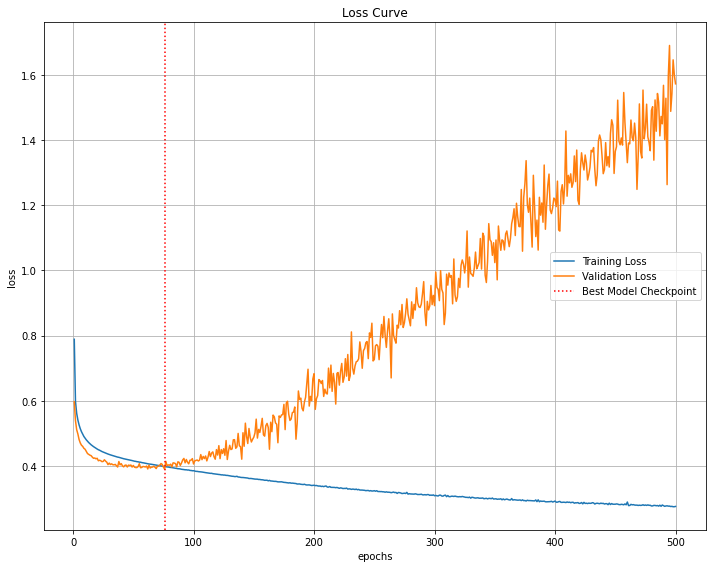

In [10]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='Validation Loss')

minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='dotted', color='r',label='Best Model Checkpoint')

plt.title('Loss Curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/loss_plot.png', bbox_inches = 'tight')

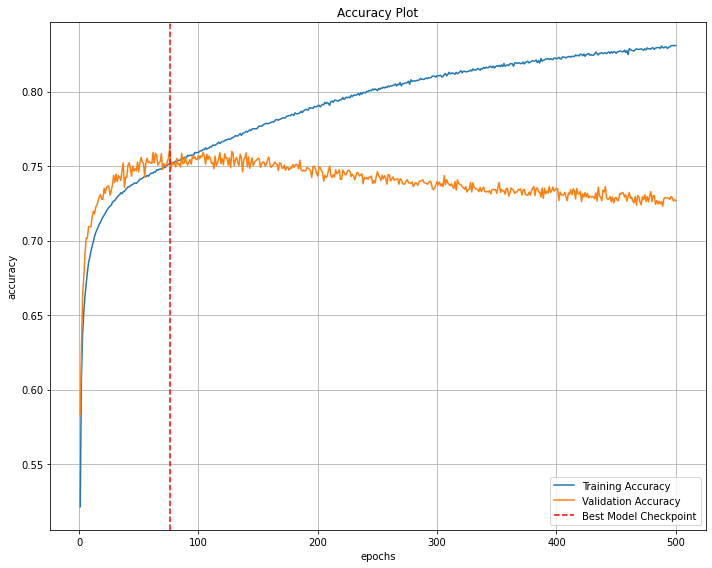

In [11]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc)+1), train_acc, label='Training Accuracy')
plt.plot(range(1,len(valid_acc)+1), valid_acc, label='Validation Accuracy')

minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='--', color='r',label='Best Model Checkpoint')

plt.title('Accuracy Plot')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/accuracy_plot.png', bbox_inches = 'tight')

### Test Label 이 존재할 경우

In [12]:
test_data = pd.read_csv(data_dir / test_data_name, header=None, sep='|', names=['speaker','utterance','tag'])

x_test, y_test = test_data['utterance'], test_data['tag']

text_preprocess_pipeline = [sent_tokenize, stemming]
x_test = x_test.apply(preprocess_text, processing_function_list=text_preprocess_pipeline)

x_test = list(convert_token_to_idx(x_test, token2idx))
y_test = list(convert_label_to_idx(y_test, label2idx))

test_ds = DAdataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=64, collate_fn=test_ds.collate_fn, drop_last=True)

In [13]:
summ = evaluate(model, test_dl, {'loss': loss_fn, 'acc': acc}, device)

summary_manager = SummaryManager(save_dir)
summary_manager.load('summary.json')
summary_manager.update(summ)
summary_manager.save('summary.json')

print('loss: {:3f}, acc: {:.2%}'.format(summ['loss'], summ['acc']))

steps: 100%|██████████| 63/63 [00:00<00:00, 257.90it/s]

loss: 0.445932, acc: 70.65%


https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222
https://quokkas.tistory.com/entry/pytorch%EC%97%90%EC%84%9C-EarlyStop-%EC%9D%B4%EC%9A%A9%ED%95%98%EA%B8%B0
https://simonjisu.github.io/nlp/2018/07/05/packedsequence.html
https://nbviewer.jupyter.org/github/simonjisu/pytorch_tutorials/blob/master/00_Basic_Utils/02_PackedSequence.ipynb

데이터 전처리: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=qbxlvnf11&logNo=221434157182

pretrained 사용: https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222